# BUSINESS UNDERSTANDING

### CRISP-DS

In [ ]:
from IPython.display import Image
Image( 'img/CRISP.png' )

# 0 IMPORTS

In [2]:
import pandas as pd
import warnings
import inflection
import math
import numpy as np
import datetime
from scipy import stats as ss
import random
import pickle


from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt


from IPython.core.display import HTML
from IPython.display import Image


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.ensemble      import RandomForestRegressor
import xgboost as xgb


from boruta import BorutaPy


warnings.filterwarnings('ignore')

## 0.1 Helper Functions

In [3]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    
    # Cramer V overstimation correction.
    chi2_ = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    k_ = k - (k-1)**2/(n-1)
    r_ = r - (r-1)**2/(n-1)
    
    
    return np.sqrt( (chi2_/n) / ( min( k_-1, r_-1 ) ) )



def jupyter_settings():
    %matplotlib inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [ 25, 10 ]
    plt.rcParams['font.size'] = 12
    
    display( HTML( '<style>.container { width:100% !important; }</style>' ) )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
    

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name,
                           'MAE': mae,
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )



def cross_validation_timeseries( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:    
            print( '\nKFold Number: {}'.format(k) )
        # start and end date for validation
        valid_start_date = x_training['date'].max() - datetime.timedelta( days=6*7 * k )
        valid_end_date = x_training['date'].max() - datetime.timedelta( days=6*7 * (k-1) ) 

        # filtering dataset
        training = x_training[ x_training['date'] < valid_start_date ]
        validation = x_training[ ( x_training['date'] >= valid_start_date ) & ( x_training['date'] <= valid_start_date ) ]

        # training and validation dataset
        # training
        xtraining = training.drop( [ 'date', 'sales' ], axis=1 )
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( [ 'date', 'sales' ], axis=1 )
        yvalidation = validation['sales']


        # Model
        m = model.fit( xtraining, ytraining )

        # Prediction
        yhat = m.predict( xvalidation )

        # Performance
        m_result = ml_error( 'Linear Regression', np.expm1(yvalidation), np.expm1(yhat) )

        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    # Performance results
    return pd.DataFrame( { 'Model Name': model_name,
                           'MAE CV': np.round( np.mean(mae_list), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                           'MAPE CV': np.round( np.mean(mape_list), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                           'RMSE CV': np.round( np.mean(rmse_list), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0])

In [4]:
jupyter_settings()

## 0.2 Loading Data

CRISP-DS: DATA EXTRACTION (usually comes from SQL queries to here)

In [5]:
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory=False )
df_store_raw = pd.read_csv( 'data/store.csv', low_memory=False )

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store')

In [6]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
838228,534,1,2013-06-10,5670,462,1,0,0,0,d,a,1200.0,9.0,2009.0,1,45.0,2009.0,"Jan,Apr,Jul,Oct"


# 1 DATA DESCRIPTION

CRISP-DS: DATA CLEANING

In [7]:
df1 = df_raw.copy()

## 1.1 Rename Columns

Renaming columns can make life easier through the project. Check it out!

In [8]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [9]:
cols_old = df1.columns

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# rename
df1.columns = cols_new

In [10]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

Here we define the proper tools to deal with the dataset. Is my computer enough? Do I need a cloud server or use Spark?

In [11]:
print( 'Number of rows: {}'   .format( df1.shape[0] ) )
print( 'Number of columns: {}'.format( df1.shape[1] ) )

Number of rows: 1017209
Number of columns: 18


## 1.3 Data Types

Is your dataset assigned with proper data types? Usually Pandas assign non numbers as objects, so we fix it here if necessary.

Even though we cannot reassign type of columns that have NA values, it's good to preparate those that are ready.

In [12]:
type_value_analysis = pd.concat([df1.dtypes, df1.isna().sum()], axis=1, keys=['Data Types', 'Missing Values'])
print(type_value_analysis)

                             Data Types  Missing Values
store                             int64               0
day_of_week                       int64               0
date                             object               0
sales                             int64               0
customers                         int64               0
open                              int64               0
promo                             int64               0
state_holiday                    object               0
school_holiday                    int64               0
store_type                       object               0
assortment                       object               0
competition_distance            float64            2642
competition_open_since_month    float64          323348
competition_open_since_year     float64          323348
promo2                            int64               0
promo2_since_week               float64          508031
promo2_since_year               float64         

In [13]:
# Reassigning the column 'date' as datetime.
df1['date'] = pd.to_datetime( df1['date'] )

# Even though columns of week, month and year are assigned with float, we cannot change it due to missing values in it.
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

What's the amount of NA?

What's the reason for them?

Depending on how it appears, there are some approaches we can take.

In [14]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

Some approaches are:
- Delete them: fast and easy! (but can backfire, then experiment other option too)
- Use ML slgorithms to fill it.
- Analyze the Business context, information and come up with solutions.

In [15]:
# competition_distance: distance in meters to the nearest competitor store

# Hypothesis:
# 1. There is no competitor;
# 2. They are too far away.

# Solution #01:
# Change missing data to a distance waaay bigger than any other competitor distance.


# Take max distance:
max_dist = df1['competition_distance'].max()

# Make the NA values significantly bigger distance than max_dist (times 3 in this case).
df1['competition_distance'] =  df1['competition_distance'].apply( lambda x: (3*max_dist) if math.isnan( x ) else x )

In [16]:
# Check NA again for competition_distance
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [17]:
# competition_open_since_month/year: gives the approximate month/year of the time the nearest competitor was opened

# Hypothesis:
# 1. Competition opened store before us;
# 2. It was simply not record.

# Solution #01:
# Use the column 'date' as reference for the opening of competition and watch the impact on the ML algorithms.

df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

In [18]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month         0
competition_open_since_year          0
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [19]:
# promo2_since_week/year: describes the year and calendar week when the store started participating in Promo2


# Hypothesis:
# 1. promo2 == 0.

# Check hypothesis:
# df1.loc[ df1['promo2'] == 0, ['promo2_since_week', 'promo2_since_year'] ].isna().sum()
# Looks perfect!

# Solution #01:
# Fill NA with 'date' values.

df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

In [20]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month         0
competition_open_since_year          0
promo2                               0
promo2_since_week                    0
promo2_since_year                    0
promo_interval                  508031
dtype: int64

In [21]:
# promo_interval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. 
# E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


# Hypothesis:
# 1. promo2 == 0

# Check hypothesis?
# df1.loc[ df1['promo2'] == 0, [ 'promo_interval'] ].isna().sum()
# Looks perfect!

# Solution #01:
# Fill NA with zeros: no promotion interval.

df1['promo_interval'].fillna( 0, inplace=True )

In [22]:
# CHECKING IF CONTINUING PROMOTION ('promo2') IS HAPPENING IN EACH SALE

# promo_interval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. 
# E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# Map month of each sale.
month_map = { 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec' }
df1['month_map'] = df1['date'].dt.month.map( month_map )

# Define if there is a promo in each sale. Create a new column indicating if a sale is done with or without promotion.
df1['is_promo'] = df1[[ 'promo_interval', 'month_map' ]].apply( lambda x: ( 0 if x['promo_interval'] == 0 
                                                                            else ( 1 if x['month_map'] in x['promo_interval'].split( ',' ) 
                                                                                   else 0 ) ), axis=1 )

In [23]:
# Check if NAs are gone.
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change types

After dealing with missing values, we can fix every column type properly.

In [24]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [25]:
# Reassign week, month and year columns as integers.
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year']  = df1['competition_open_since_year'].astype( int )
df1['promo2_since_week']            = df1['promo2_since_week'].astype( int )
df1['promo2_since_year']            = df1['promo2_since_year'].astype( int )

In [26]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical Analysis

Métricas de: 
- Tendência central
- Dispersão

Encontrar erros grotescos

In [27]:
num_attributes =  df1.select_dtypes( include=[ 'int32', 'int64', 'float64' ] )
cat_attributes =  df1.select_dtypes( exclude=[ 'int32', 'int64', 'float64', 'datetime64[ns]' ] )


In [28]:
cat_attributes.sample(3)

,state_holiday,store_type,assortment,promo_interval,month_map
975846,0,c,c,0,Feb
158341,0,a,c,"Jan,Apr,Jul,Oct",Mar
400239,0,d,a,0,Jul


### 1.7.1 Numerical Attributes

In [29]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

m = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
m.columns = [ 'attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,227580.0,227560.0,6007.076294,2330.0,13682.728423,11.512969,177.136255
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<Axes: xlabel='sales', ylabel='Density'>

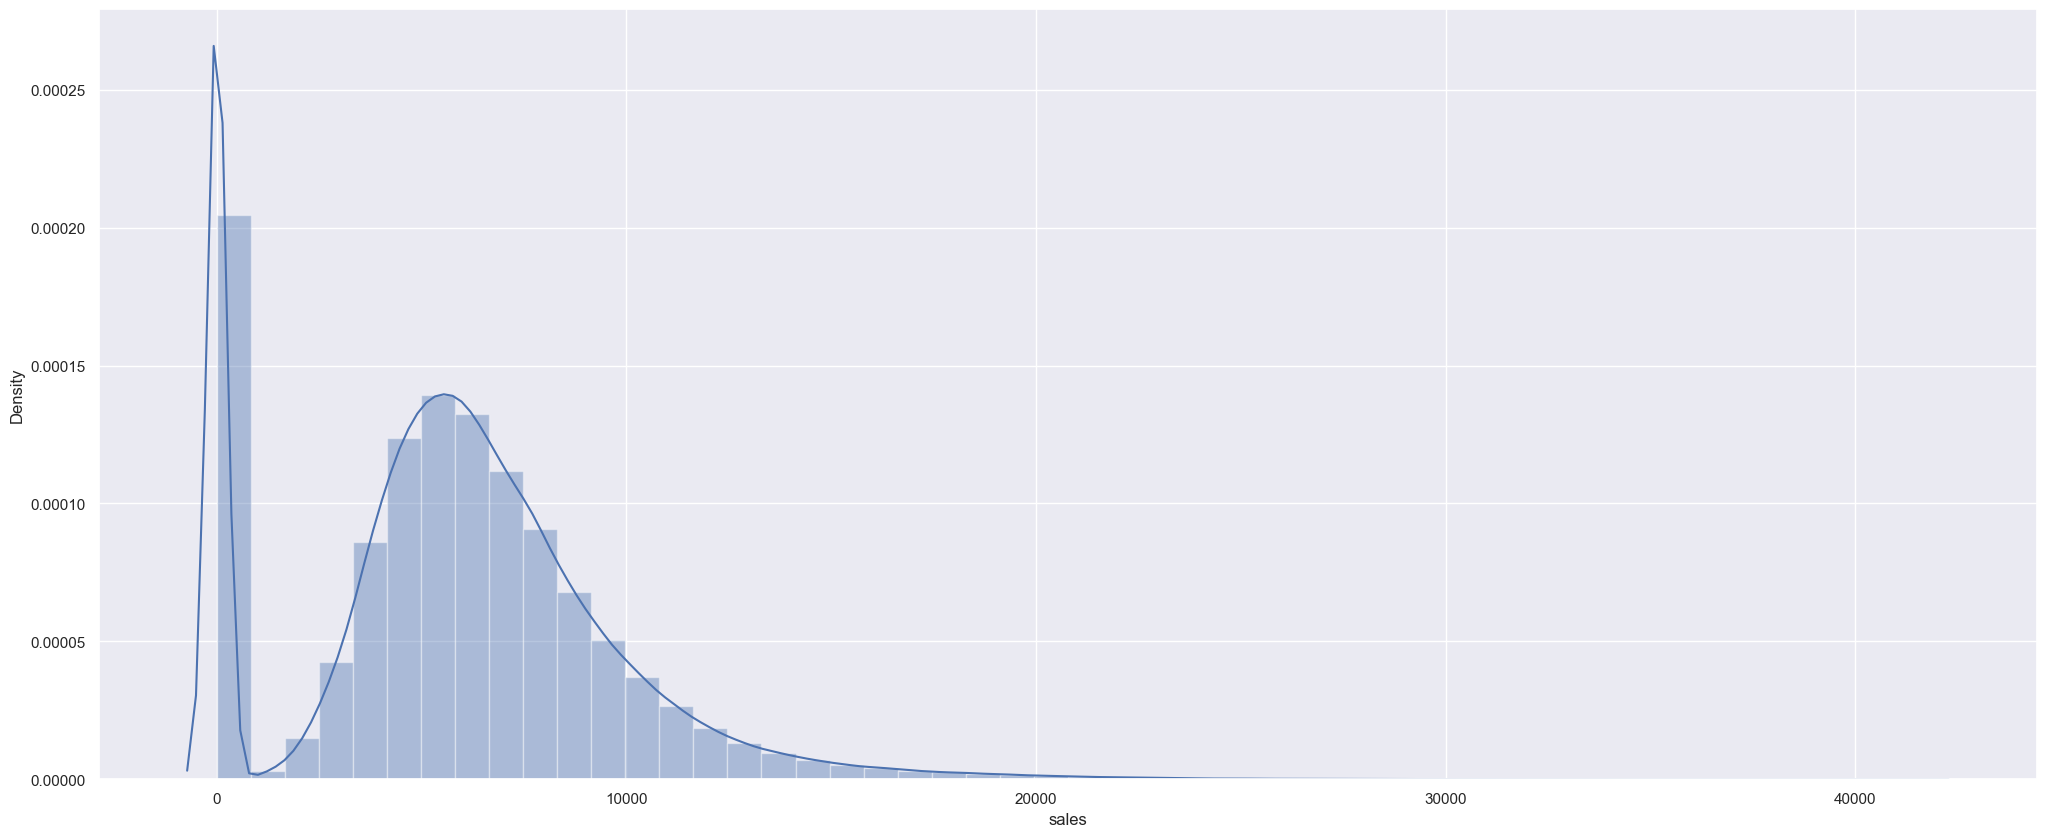

In [30]:
sns.distplot( df1['sales'] )

### 1.7.2 Categorical Attributes

In [31]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

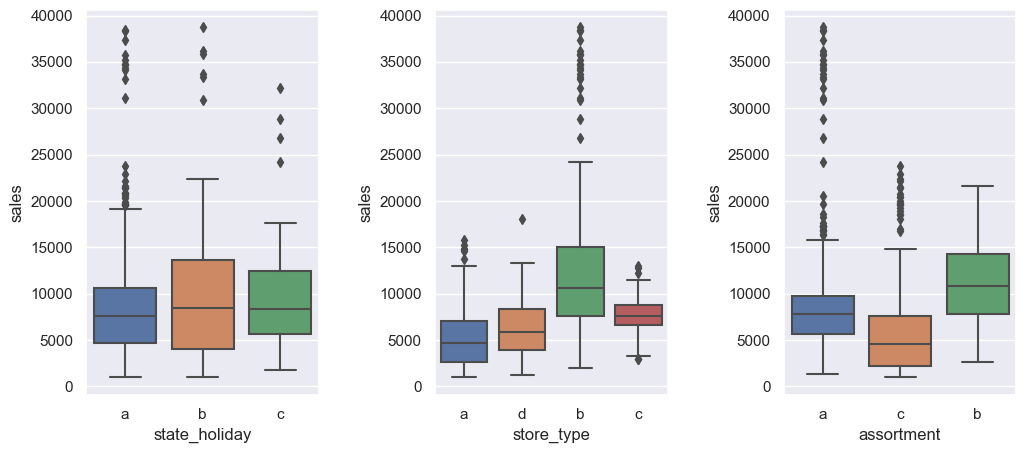

In [32]:
aux1 = df1[ ( df1['state_holiday'] != '0' ) & ( df1['sales'] != 0) ]


# Plotting boxplot
fig, axes = plt.subplots(1, 3, figsize=(12, 5), gridspec_kw={'wspace': 0.5})

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux1 )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux1 )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux1 )

plt.show()

# 2 FEATURE ENGINEERING

CRISP-DS: DATA CLEANING

In [33]:
df2 = df1.copy()

Why do it now?

## 2.0 Hypothesis Mindmap

MINDMAP DE HIPÓTESES
- qual fenômeno estou modelando? Daily Store Sales
- quem são os agentes atuantes sobre o fenômeno
- qual a descrição dos agentes?
- Validação ou não das hipóteses: surpresa ou quebra de crença

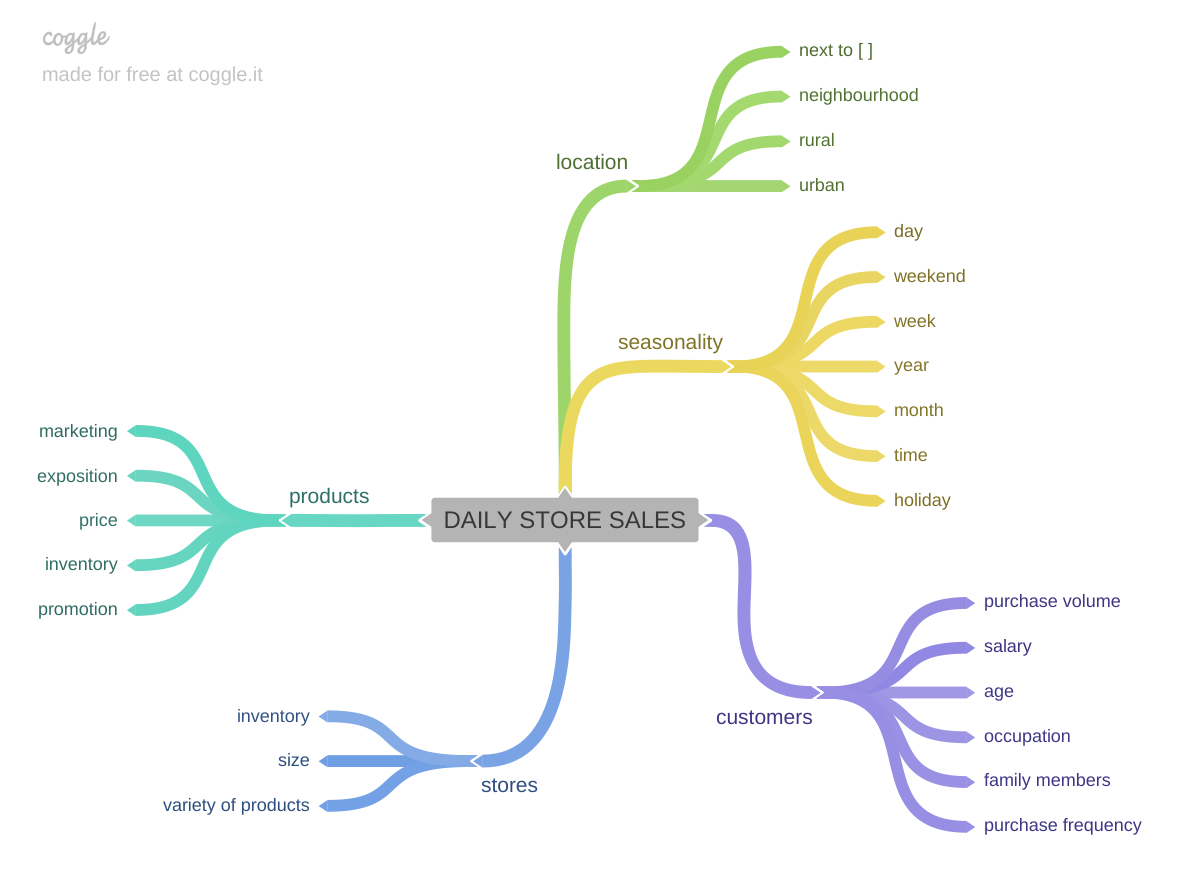

In [34]:
# This should come from BUSINESS UNDERSTANDING and will help now
Image( 'img/mindmap_hipothesis.png' )

HIPÓTESES SÃO APOSTAS:

LOJAS MAIORES - MAIS VENDA

MAIOR VARIEDADE - MAIS VENDA

COMPETIDORES MAIS PERTO - MENOS VENDA

## 2.1 Hypothesis Creation

### 2.1.1 Store hypothesys

**1.** Mais funcionários - mais vendas

**2.** Mais estoque - mais venda

**3.** Maior porte - maior venda

**4.** Maior variedade - maior venda

**5.** Competidores mais próximos - menos venda

**6.** Competidores há mais tempo - mais venda

### 2.1.2 Product hypothesis

**1.** Mais marketing - mais venda

**2.** Mais exposição - mais venda

**3.** Preço menor - mais venda

**4.** Promoção maior / mais desconto - maior venda

**5.** Promoções mais longas - maior venda

**6.** Mais dias totais de promoção - mais venda

**7.** Promoções consecutivas - mais venda

### 2.1.3 Seasonality hypothesis

**1.** Lojas abertas no natal - mais venda

**2.** Loja vende mais ao longo dos anos

**3.** Mais venda no segundo semestre

**4.** Vender mais depois do dia 10 de cada mês

**5.** Vender menos no fim de semana

**6.** Vender menos nos feriados escolares

## 2.2 Final list of Hypothesis

PRODUTOS

**4.** Maior variedade - maior venda

**5.** Competidores mais próximos - menos venda

**6.** Competidores mais recentes - menos venda

LOJAS

**5.** Promoções recorrentes há mais anos - maior venda

**6.** Mais dias totais de promoção - mais venda

**7.** Promoções consecutivas - mais venda

SAZONALIDADE

**1.** Lojas abertas no natal - mais venda

**2.** Loja vende mais ao longo dos anos

**3.** Mais venda no segundo semestre (foco em dezembro)

**4.** Vender mais nos 10 primeiros dias de cada mês (salário recebido)

**5.** Vender menos no fim de semana

**6.** Vender menos nos feriados escolares

## 2.3 Feature Engineering

In [35]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week_of_year
df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype( int )


# year_week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )



# competition_since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
df2['competition_time_in_months'] = ( ( df2['date'] - df2['competition_since'] ) / 30 ).apply( lambda x: x.days ).astype( 'int64' )


# promo_since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
# "%Y-%W-%w has week 1 as the week after the year's first sunday.
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', "%Y-%W-%w" ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] ) / 7 ).apply( lambda x: x.days ).astype( 'int64' )


# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state_holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

In [36]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
year                                     int32
month        

In [37]:
df2.sample(5).T

,772308,890817,554619,663504,55094
store,399,718,135,865,460
day_of_week,4,3,3,4,5
date,2013-08-08 00:00:00,2013-04-24 00:00:00,2014-02-19 00:00:00,2013-11-14 00:00:00,2015-06-12 00:00:00
sales,4454,7985,5439,5906,3386
customers,501,885,488,539,339
open,1,1,1,1,1
promo,0,1,1,0,0
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,0,0,0,0
store_type,a,a,d,d,a


# 3 FILTRAGEM DE VARIÁVEIS

CRISP-DS: DATA CLEANING

In [38]:
df3 = df2.copy()

FILTRAGEM DE VARIÁVEIS

- Restrições do negócio

SELEÇÃO DE VARIÁVEIS 
- Variáveis mais relevantes para o MODELO

In [ ]:
df3.head().T

## 3.1 Filtragem das linhas

In [40]:
df3 = df3[ df3['open'] != 0 ]

In [41]:
# Exemplo de restrição: certa categoria tem 80% das vendas, beleza e cosméticos. Faz-se uma análise usando só esta categoria.

## 3.2 Seleção das colunas

In [42]:
# Deletando 'open' porque só tem valor == 1,
# Deletando 'promo_interval' e 'month_map' porque já foram usada para criar 'is_promo',
# Deletando 'customers' porque não teremos informação de quantos clientes teremos.
# Assim como 'customers', checar outras colunas que não existem em test.csv
cols_drop = [ 'customers', 'open', 'promo_interval', 'month_map' ]
df3 = df3.drop( cols_drop, axis=1 )

In [43]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_in_months', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4 EXPLORATORY DATA ANALYSIS - EDA

CRISP-DS: EDA

In [44]:
df4 = df3.copy()

OBJETIVOS:

1 - Ganhar experiência de negócio;

2 - Validar/Contrapor hipóteses de negócio (insights);

3 - Perceber variáveis que são importantes para o modelo.

## 4.1 Univariate Analysis

Como é a cara dessa variável? min, max, range, distribuição...

### 4.1.1 Response Variable

<Axes: xlabel='sales', ylabel='Count'>

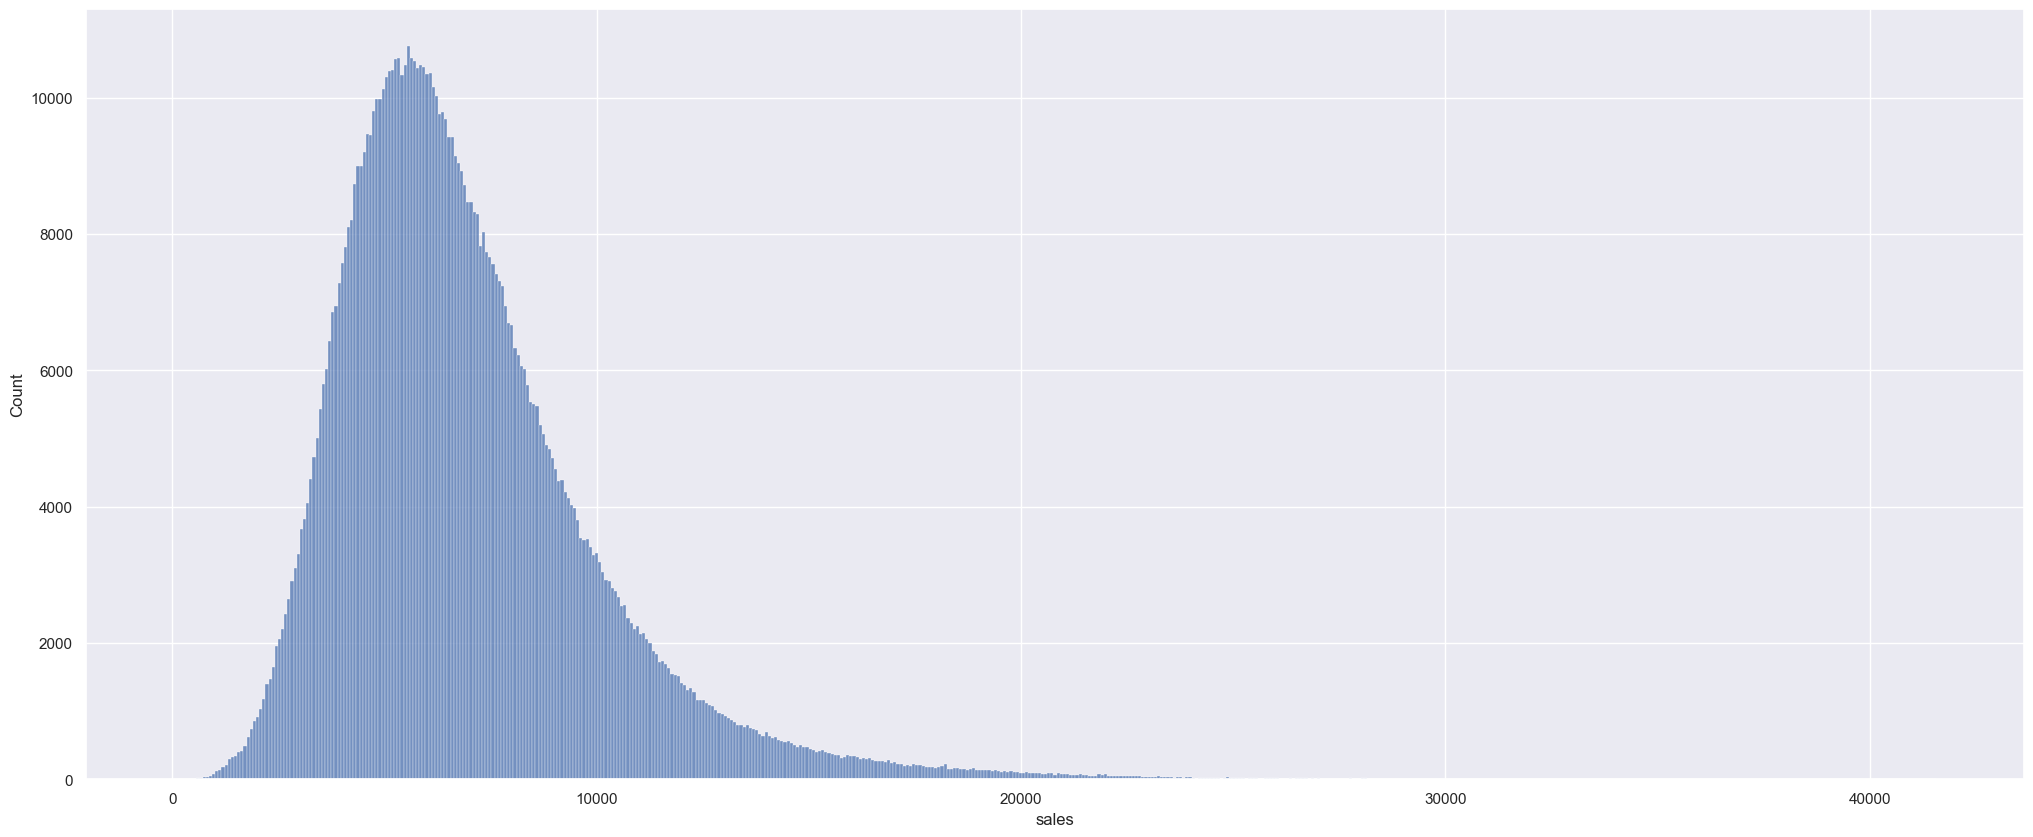

In [45]:
sns.histplot( df4['sales'] )

In [46]:
print( min( df4['sales'] ) )
print( max( df4['sales'] ) )
print( df4['sales'].mean() )
print( df4['sales'].median() )

46
41551
6955.959133664481
6369.0


### 4.1.2 Numerical Variable

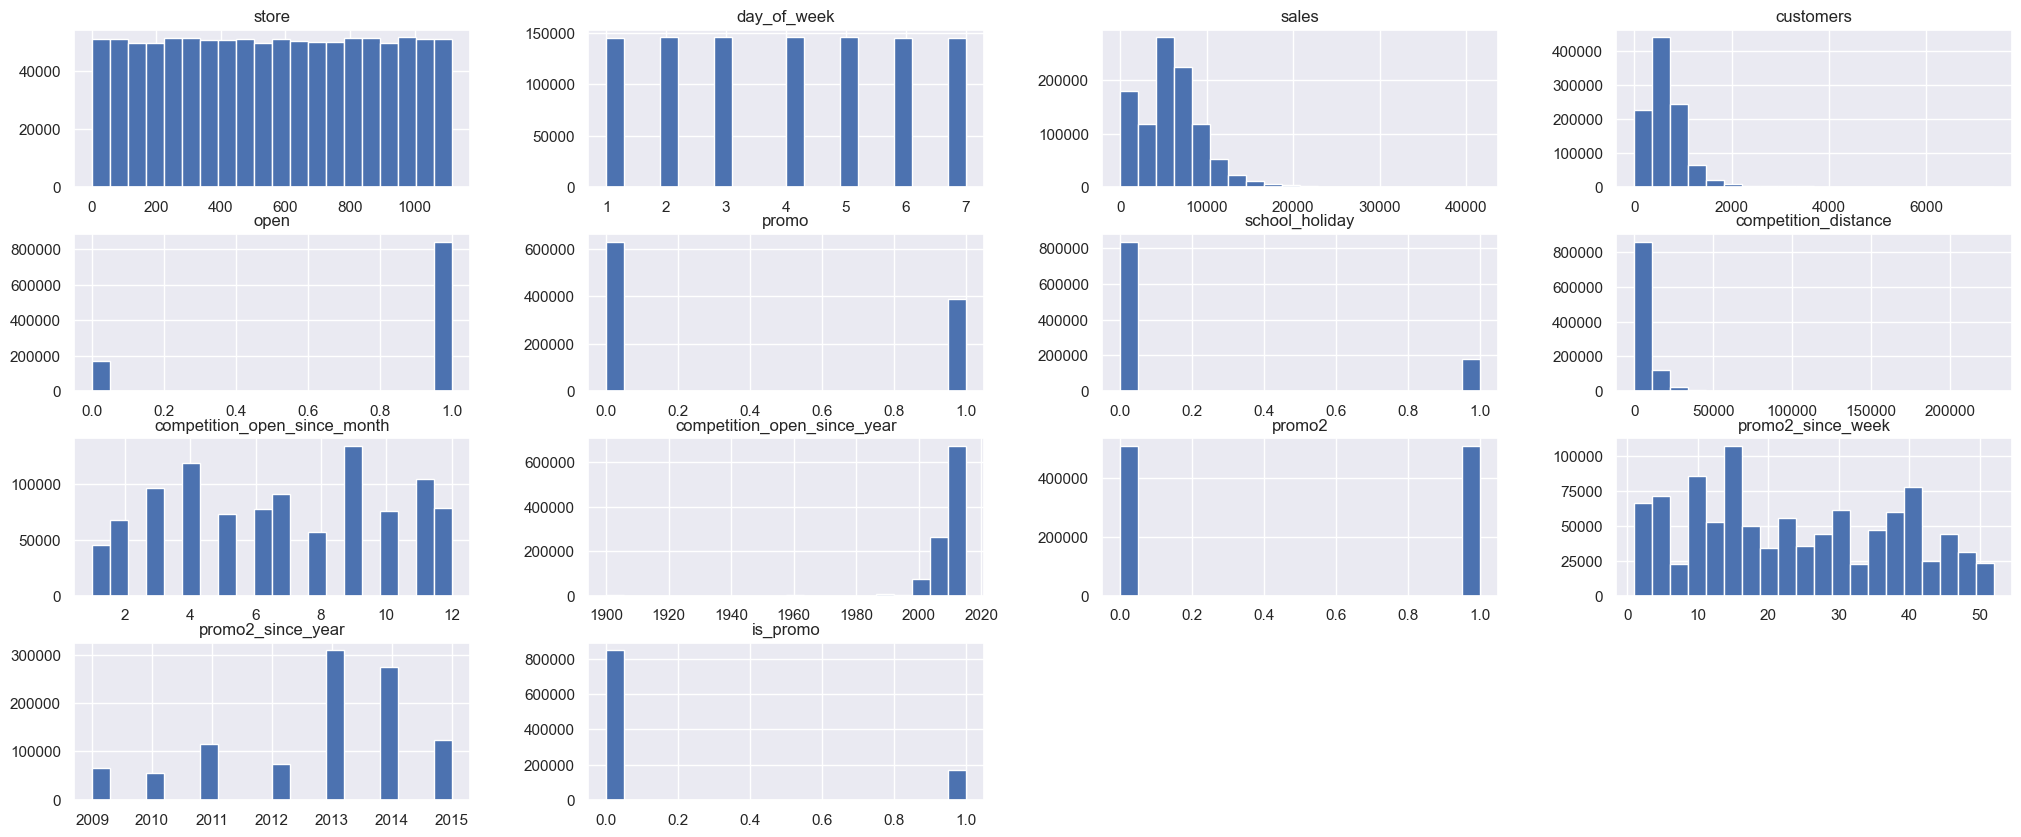

In [47]:
num_attributes.hist( bins=20 );

### 4.1.3 Categorical Variable

In [48]:
df4['state_holiday'].unique()

array(['regular_day', 'public_holiday', 'easter_holiday', 'christmas'],
      dtype=object)

In [49]:
df4['store_type'].unique()

array(['c', 'a', 'd', 'b'], dtype=object)

In [50]:
df4['assortment'].unique()

array(['basic', 'extended', 'extra'], dtype=object)

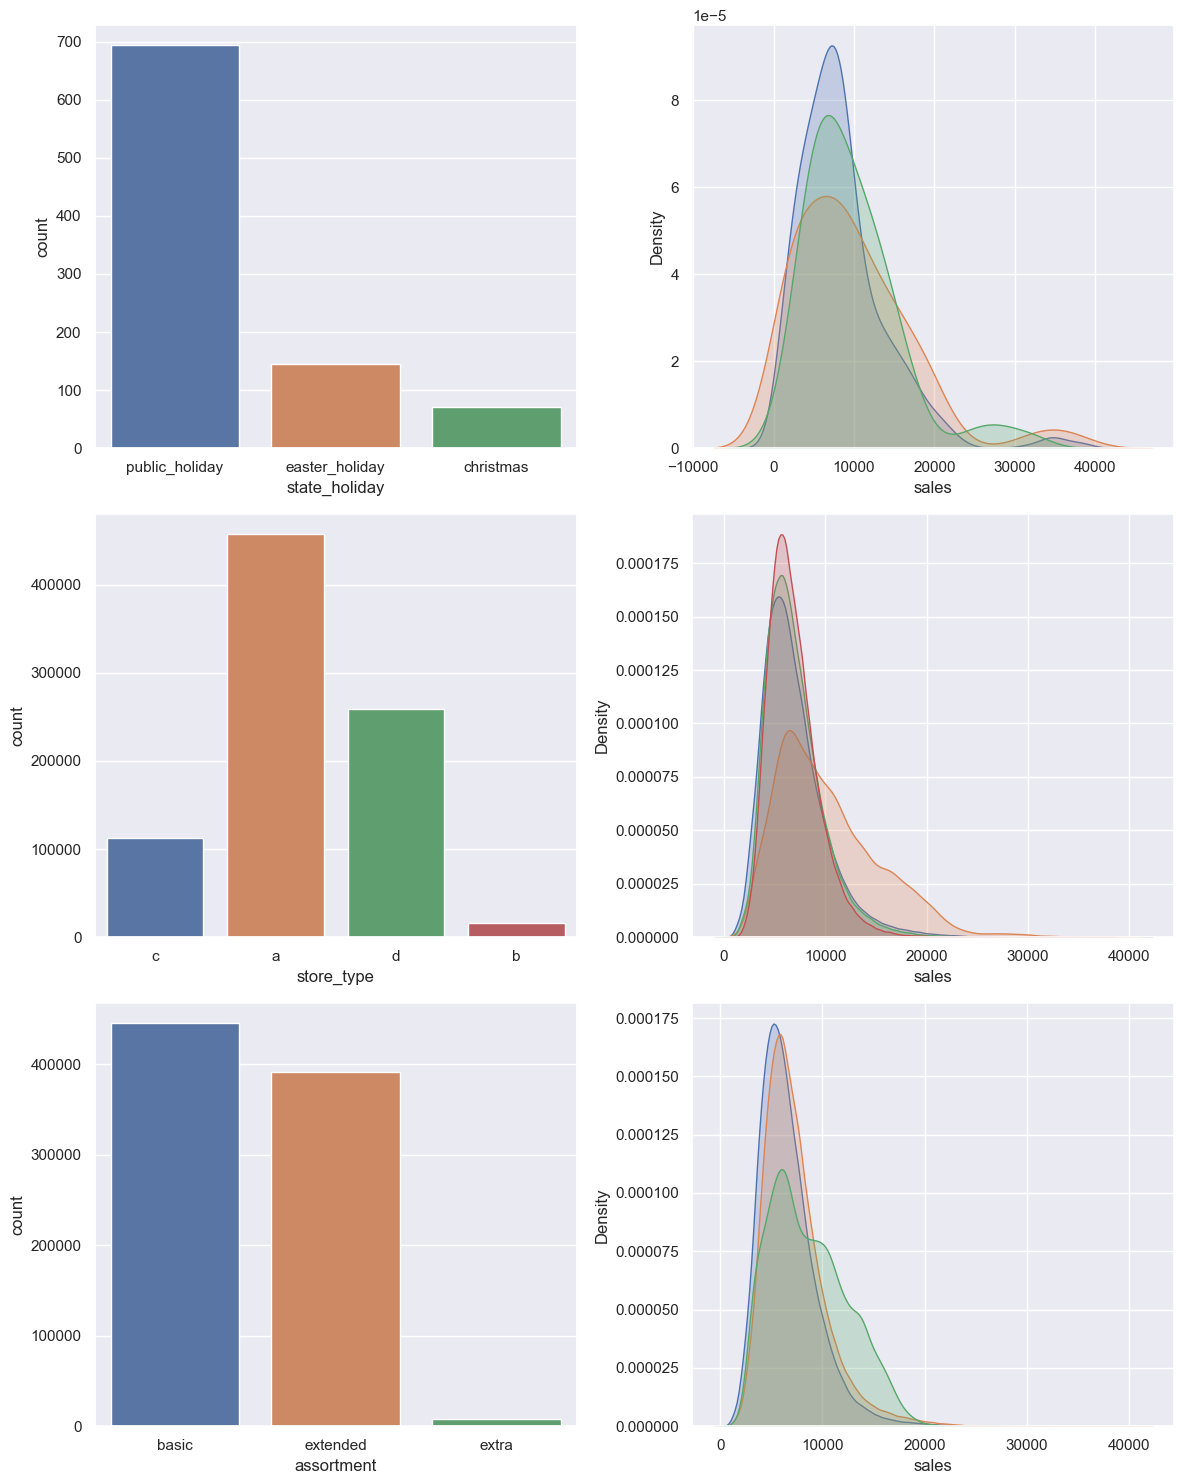

In [51]:
# Configuração da figura com espaçamento vertical ajustável
fig, axes = plt.subplots(3, 2, figsize=(12, 15), gridspec_kw={'height_ratios': [1, 1, 1]})

# Gráfico 1
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x='state_holiday', data=a, ax=axes[0, 0])

# Gráfico 2
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True, ax=axes[0, 1])
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True, ax=axes[0, 1])
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True, ax=axes[0, 1])

# Gráfico 3
sns.countplot(x='store_type', data=df4, ax=axes[1, 0])

# Gráfico 4
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', fill=True, ax=axes[1, 1])
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', fill=True, ax=axes[1, 1])
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', fill=True, ax=axes[1, 1])
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', fill=True, ax=axes[1, 1])

# Gráfico 5
sns.countplot(x='assortment', data=df4, ax=axes[2, 0])

# Gráfico 6
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True, ax=axes[2, 1])
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True, ax=axes[2, 1])
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True, ax=axes[2, 1])

# Ajuste do layout
plt.tight_layout()
plt.show()

## 4.2 Bivariada

Como certa variável impacta a variável resposta? Correlação, validação das hipóteses...

#### H1: Maior variedade - maior venda
**VERDADEIRA** Lojas 'extra' e 'extended' vendem mais que a 'basic', MAS tem bem menos lojas com maior variedade.

<Axes: xlabel='year_week'>

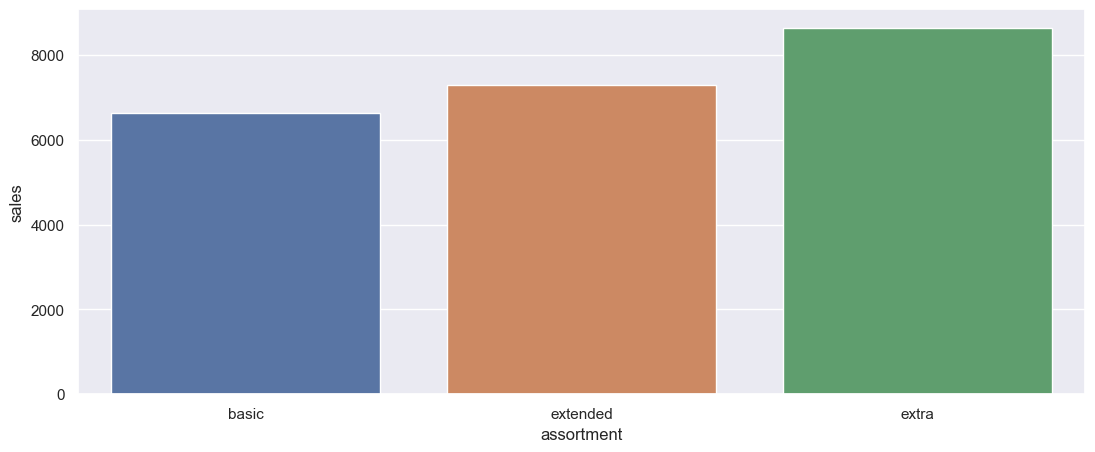

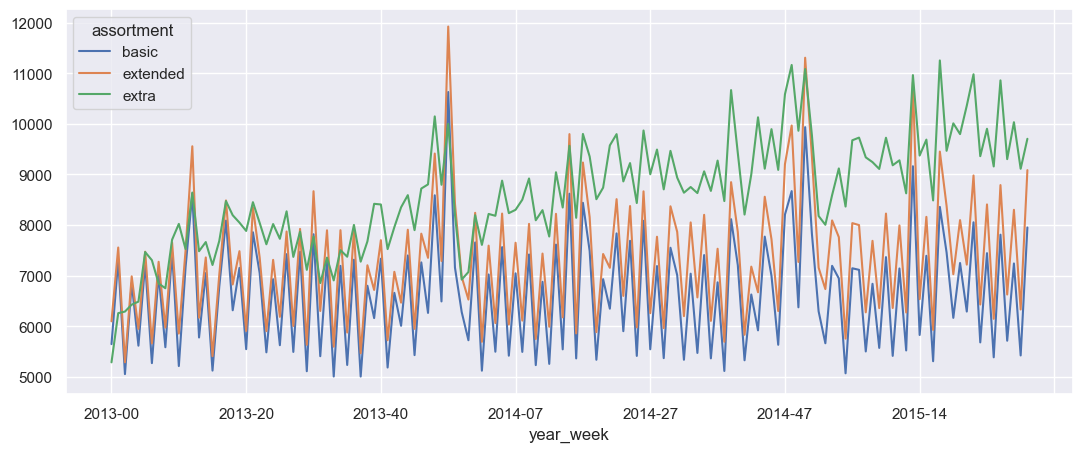

In [52]:
plt.rcParams['figure.figsize'] = [13, 5]

aux1 = df4[ [ 'assortment', 'sales' ] ].groupby( 'assortment' ).mean().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

# assumindo que o 'extra' é o com maior variedade de produtos


aux2 = df4[ [ 'year_week', 'assortment', 'sales' ] ].groupby( [ 'year_week', 'assortment' ] ).mean().reset_index()
aux3 = aux2.pivot( index='year_week', columns='assortment', values='sales' )
aux3.plot()

#### H2: Competidores mais próximos - menos venda
**FALSA** Não há correlação aparente.

<Axes: >

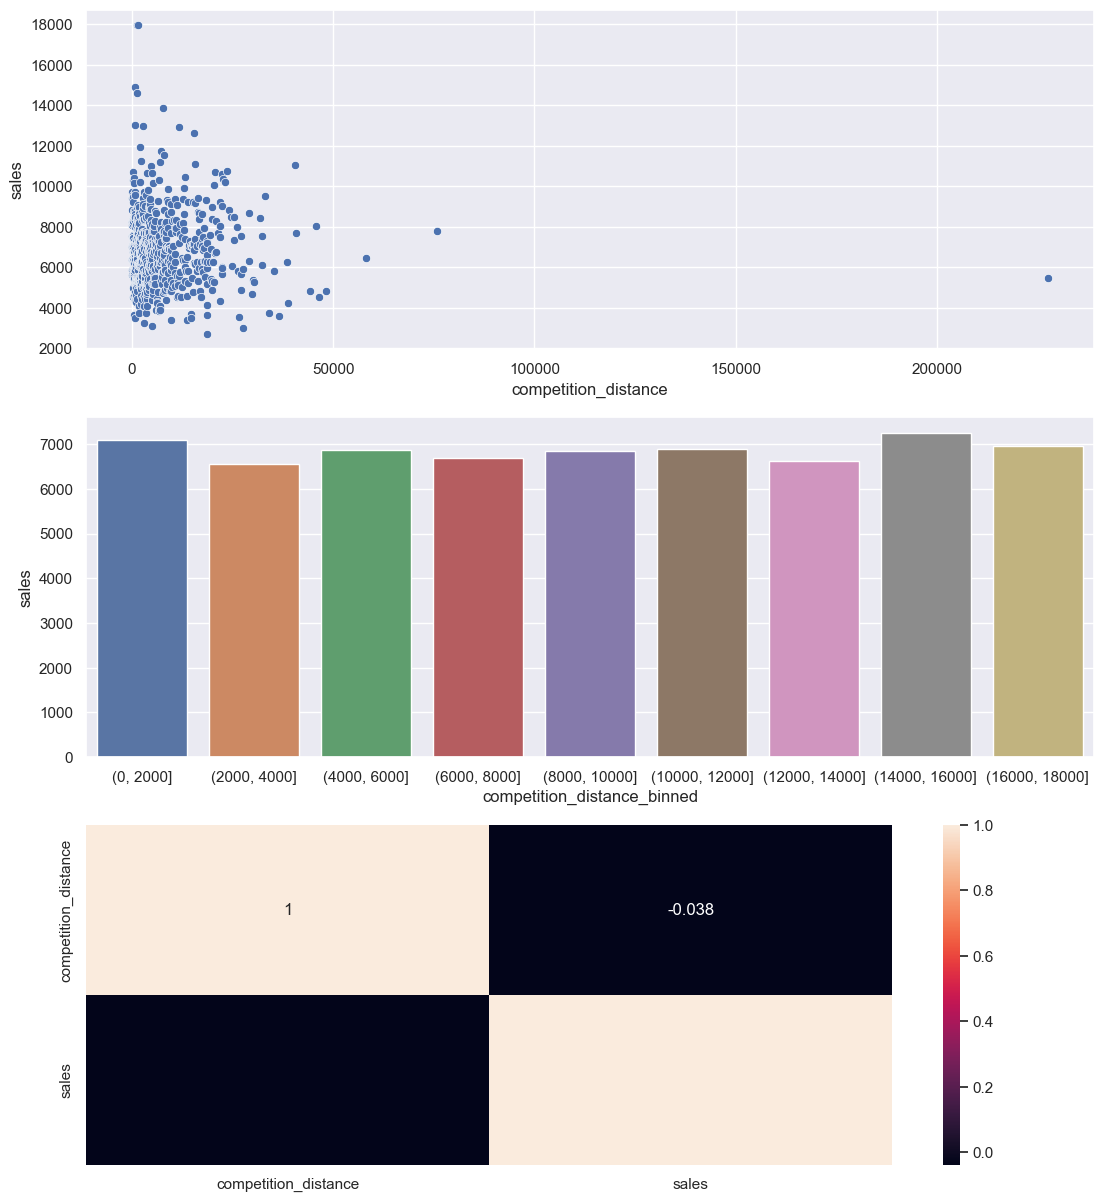

In [53]:
plt.rcParams['figure.figsize'] = [13, 15]

aux1 = df4[ [ 'competition_distance', 'sales' ] ].groupby( 'competition_distance' ).mean().reset_index()

plt.subplot( 3, 1, 1 )
sns.scatterplot( x='competition_distance', y='sales', data=aux1 )

plt.subplot( 3, 1, 2 )
bins = list( np.arange( 0, 20000, 2000 ) )
aux2 = aux1
aux2[ 'competition_distance_binned' ] = pd.cut( aux2['competition_distance'], bins=bins )
aux2 = aux2[ [ 'competition_distance_binned', 'sales' ] ].groupby( 'competition_distance_binned' ).mean().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
# plt.xticks( rotation=90 )

plt.subplot( 3, 1, 3 )
aux1 = df4[ [ 'competition_distance', 'sales' ] ].groupby( 'competition_distance' ).mean().reset_index()
sns.heatmap( aux1.corr( method='pearson' ), annot=True )

#### H3: Competidores há menos tempo - menos
**FALSA** Vende mais quanto mais recente a competição.

<Axes: >

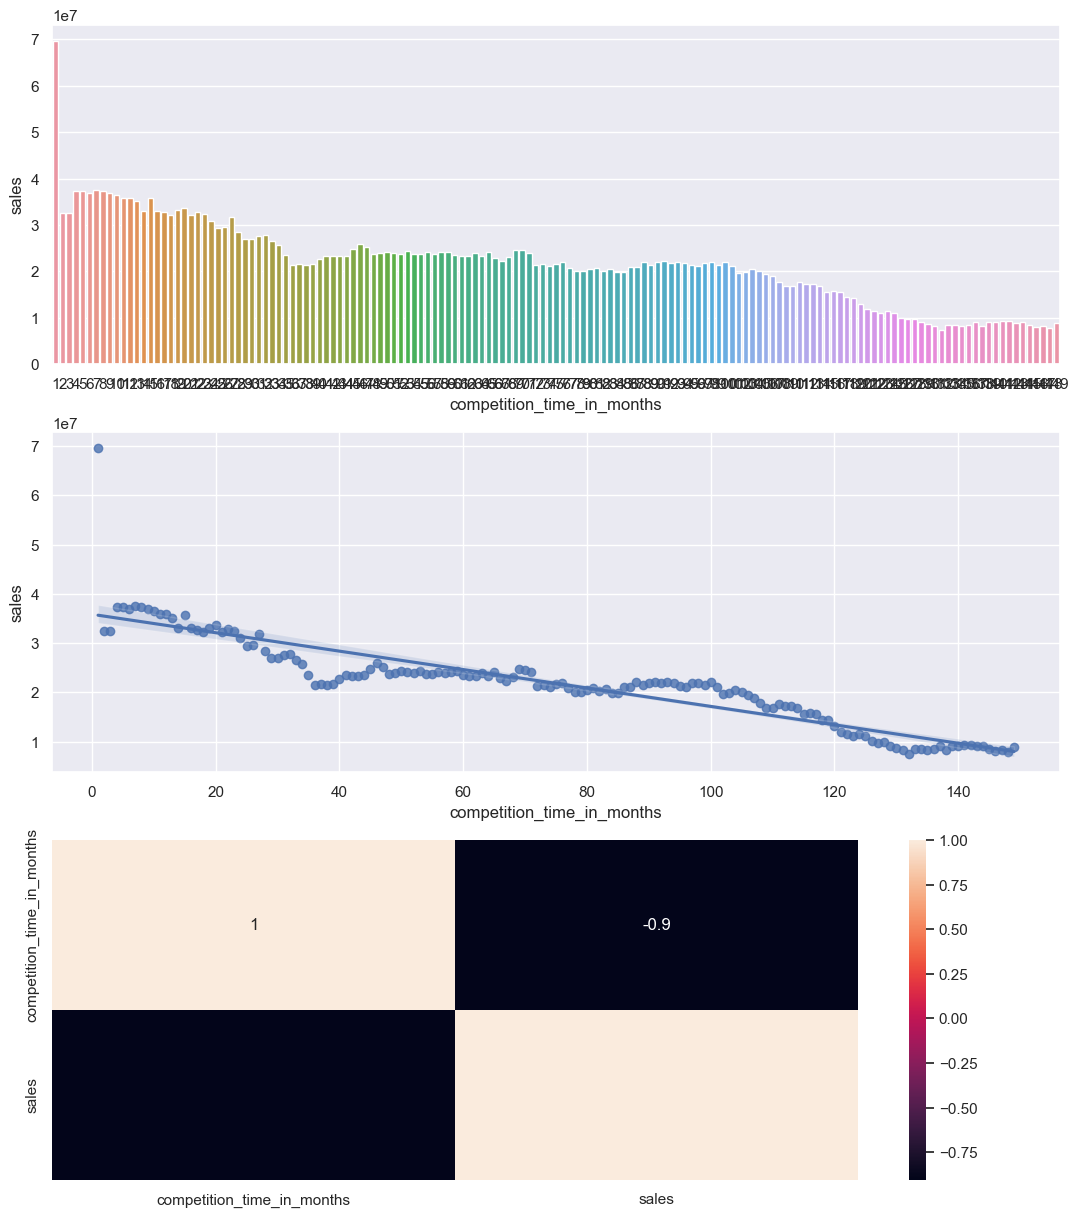

In [54]:
plt.rcParams['figure.figsize'] = [13, 15]

plt.subplot( 3, 1, 1 )
aux1 = df4[ [ 'competition_time_in_months', 'sales' ] ].groupby('competition_time_in_months').sum().reset_index()
aux2 = aux1[ ( aux1['competition_time_in_months'] < 150 ) & ( aux1['competition_time_in_months'] > 0 ) ]
sns.barplot( x='competition_time_in_months', y='sales', data=aux2 );

plt.subplot( 3, 1, 2 )
sns.regplot( x='competition_time_in_months', y='sales', data=aux2 )

plt.subplot( 3, 1, 3 )
sns.heatmap( aux2.corr( method='pearson' ), annot=True )

### H4: Promoções recorrentes há mais anos - maior venda
**FALSA** Nos primeiros anos, temos um crescimento ínfimo nas vendas e depois elas caem drasticamente.

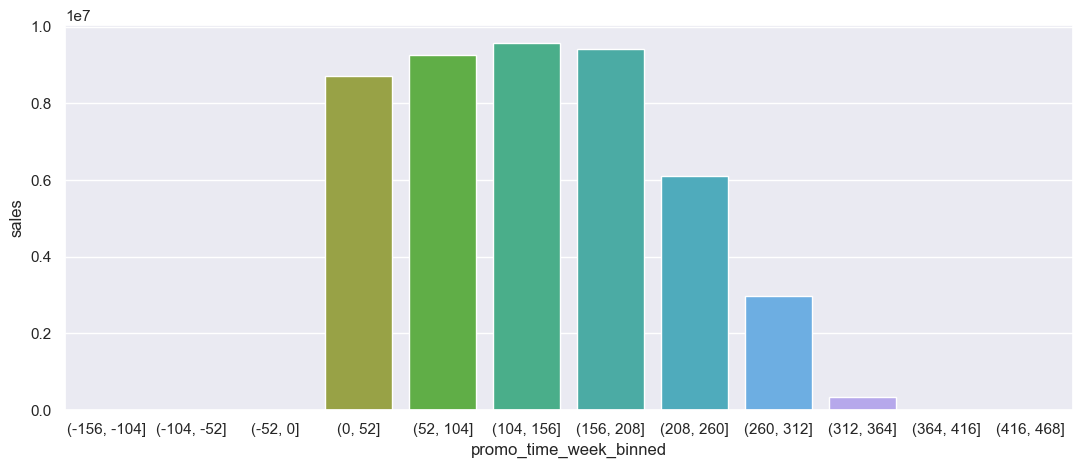

In [55]:
plt.rcParams['figure.figsize'] = [13, 5]

# aux0 = df4[ df4['is_promo'] == 1 ]
aux0 = df4
aux1 = aux0[ [ 'promo_time_week', 'sales' ] ].groupby('promo_time_week').sum().reset_index()

bins = list( np.arange( -156, 520, 52 ) )
aux2 = aux1[ aux1['promo_time_week'] > 0 ]
aux2[ 'promo_time_week_binned' ] = pd.cut( aux2['promo_time_week'], bins=bins )
aux2 = aux2[ [ 'promo_time_week_binned', 'sales' ] ].groupby( 'promo_time_week_binned' ).mean().reset_index()
sns.barplot( x='promo_time_week_binned', y='sales', data=aux2 );

### <s>H5: Mais dias totais de promoção - mais venda</s>

In [56]:
# ON HOLD


### H6: Promoções recorrentes - mais venda
**FALSA** Lojas com promo2 vendem menos.

In [57]:
df4[ [ 'promo', 'promo2', 'sales' ] ].groupby( [ 'promo', 'promo2' ] ).mean().reset_index()

,promo,promo2,sales
0,0,0,6328.187633
1,0,1,5529.566684
2,1,0,8618.452062
3,1,1,7836.672987


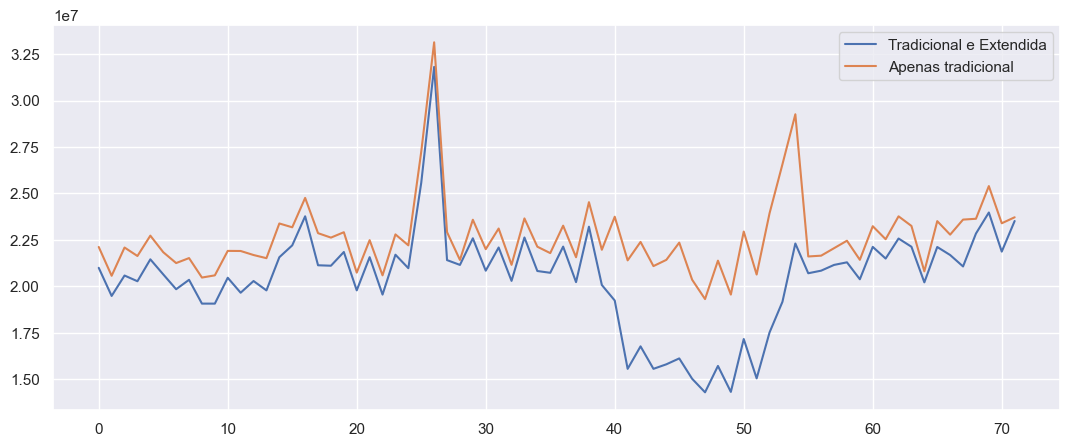

In [58]:
aux1 = df4[ ( df4['promo'] == 1 ) & ( df4['promo2'] == 1 ) ][ [ 'year_week', 'sales' ] ].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[ ( df4['promo'] == 1 ) & ( df4['promo2'] == 0 ) ][ [ 'year_week', 'sales' ] ].groupby('year_week').sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional e Extendida', 'Apenas tradicional'] );

### H7: Lojas abertas nos feriados - mais venda
**VERDADEIRA** Realmente vendem mais, aparentemente 10% a mais.

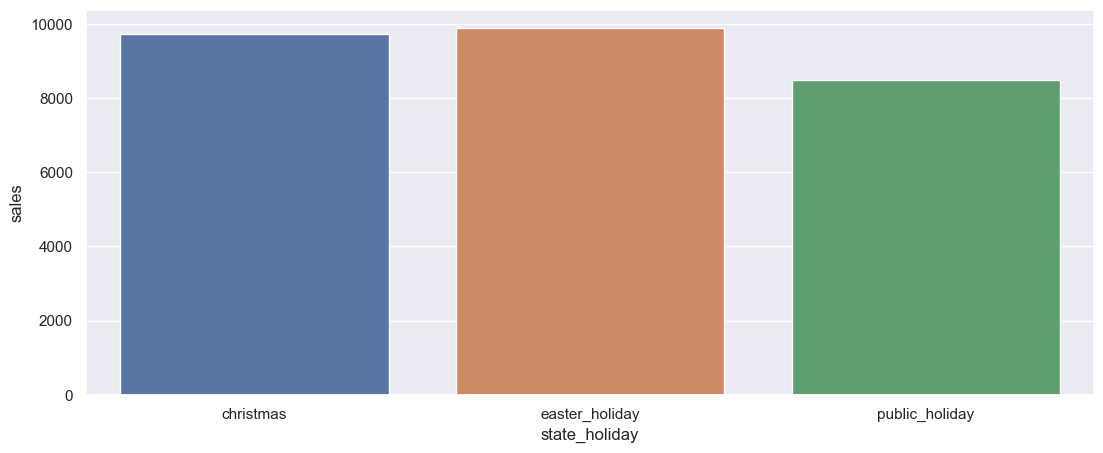

In [59]:
aux1 = df4[ df4['state_holiday'] != 'regular_day' ]
aux1 = aux1[ [ 'state_holiday', 'sales' ] ].groupby( 'state_holiday' ).mean().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

### H8: Loja vende mais ao longo dos anos.
**FALSA** Houve uma queda anual. **MAS** houve um crescimento nas vendas nos primeiros semestres **E** uma queda grande no último trimestre.

**FOCO** para as vendas do último trimestre de 2015, que vem à frente.

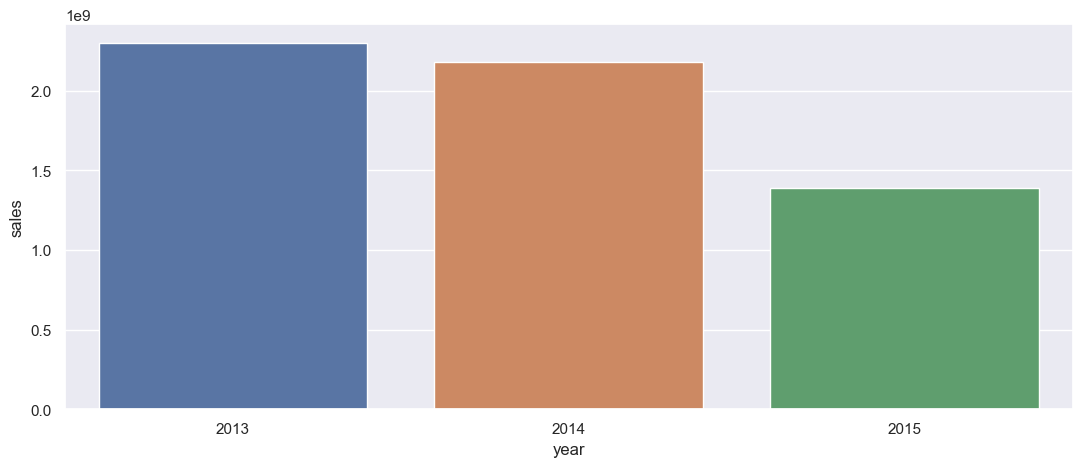

In [60]:
aux1 = df4[ [ 'year', 'sales' ] ].groupby('year').sum().reset_index()
sns.barplot( x='year', y='sales', data=aux1 );

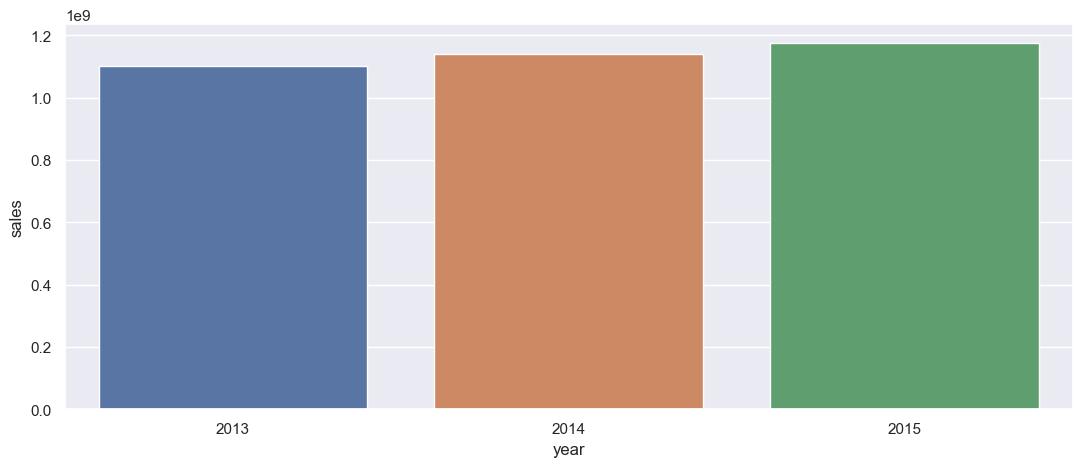

In [61]:
aux1 = df4[ df4['month'] <= 6 ]
aux1 = aux1[ [ 'year', 'sales' ] ].groupby('year').sum().reset_index()
sns.barplot( x='year', y='sales', data=aux1 );

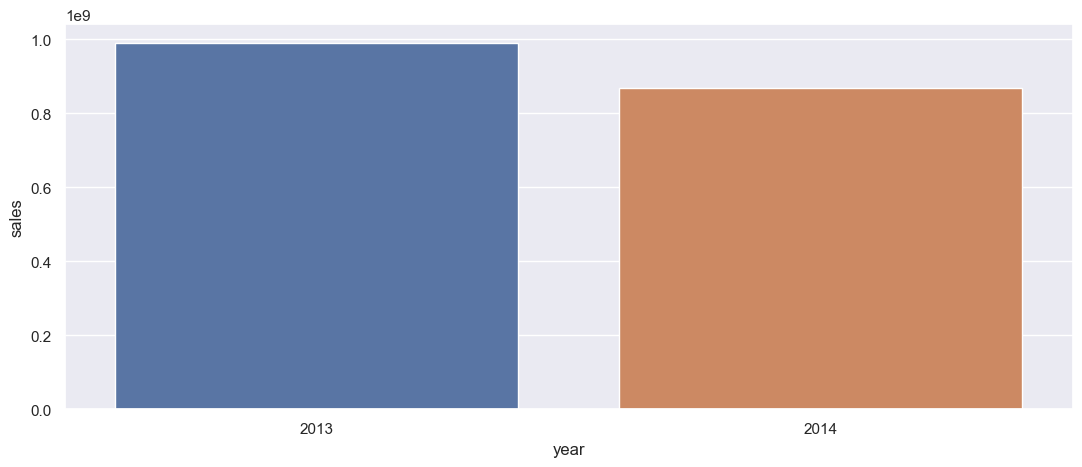

In [62]:
aux1 = df4[ df4['month'] > 7 ]
aux1 = aux1[ [ 'year', 'sales' ] ].groupby('year').sum().reset_index()
sns.barplot( x='year', y='sales', data=aux1 );

### H9: Mais venda no segundo semestre
**VERDADEIRA** Principalmente em Dezembro, as vendas são bem maiores.

<Axes: xlabel='month', ylabel='sales'>

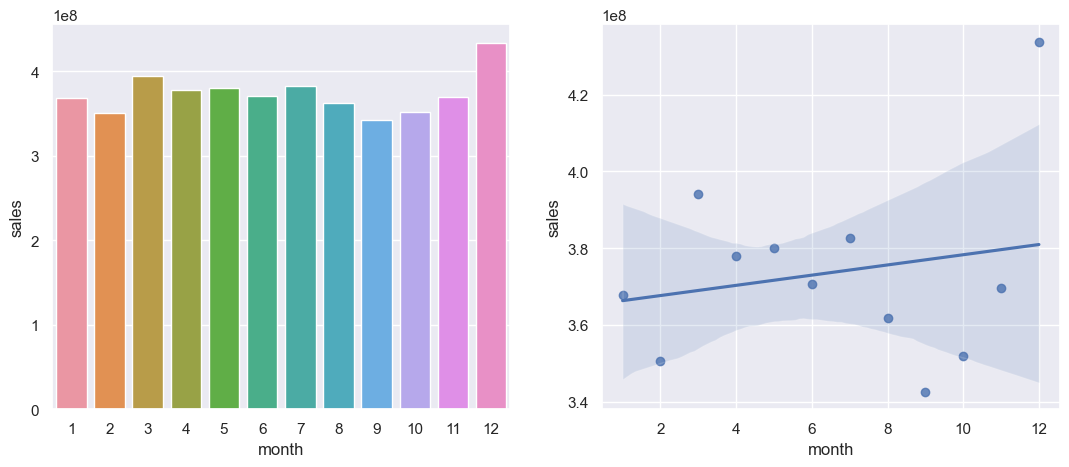

In [63]:
aux1 = df4.loc[ df4['year'] != 2015, [ 'month', 'sales' ] ].groupby('month').sum().reset_index()

plt.subplot( 1, 2, 1 )
sns.barplot( x='month', y='sales', data=aux1 )

plt.subplot( 1, 2, 2 )
sns.regplot( x='month', y='sales', data=aux1 )

### H10: Vende-se nos 10 primeiros dias: recebe-se salário.
**VERDADEIRA** Dividindo o mês em 3, o primeiro terço é o de maior venda.

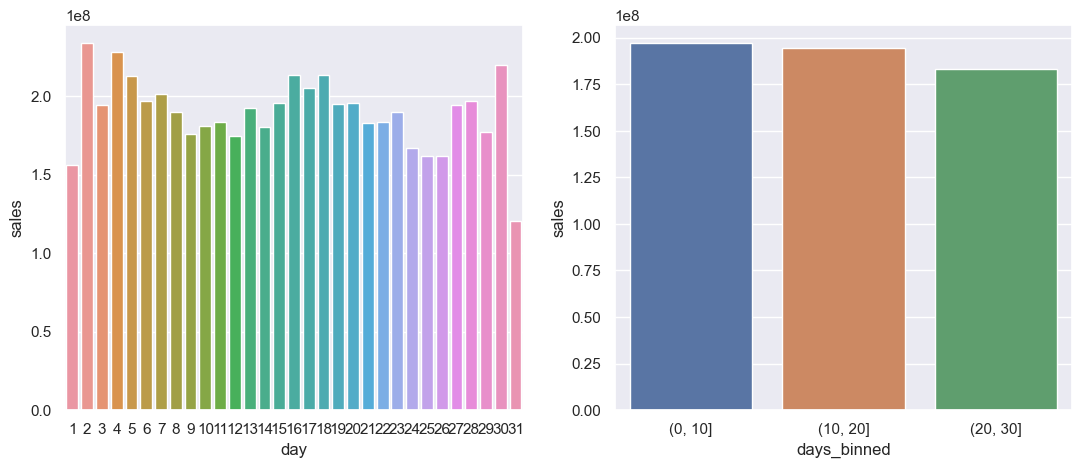

In [64]:
aux1 = df4[ [ 'day', 'sales' ] ].groupby('day').sum().reset_index()

plt.subplot( 1, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 )


plt.subplot( 1, 2, 2 )
bins = list( np.arange( 0, 31, 10 ) )
aux2 = aux1
aux2[ 'days_binned' ] = pd.cut( aux2['day'], bins=bins )
aux2 = aux2[ [ 'days_binned', 'sales' ] ].groupby( 'days_binned' ).mean().reset_index()
sns.barplot( x='days_binned', y='sales', data=aux2 );

### H11: Vender menos no fim de semana.
**VERDADEIRA** Vendem menos nos dias 6 e 7.

<Axes: xlabel='day_of_week', ylabel='sales'>

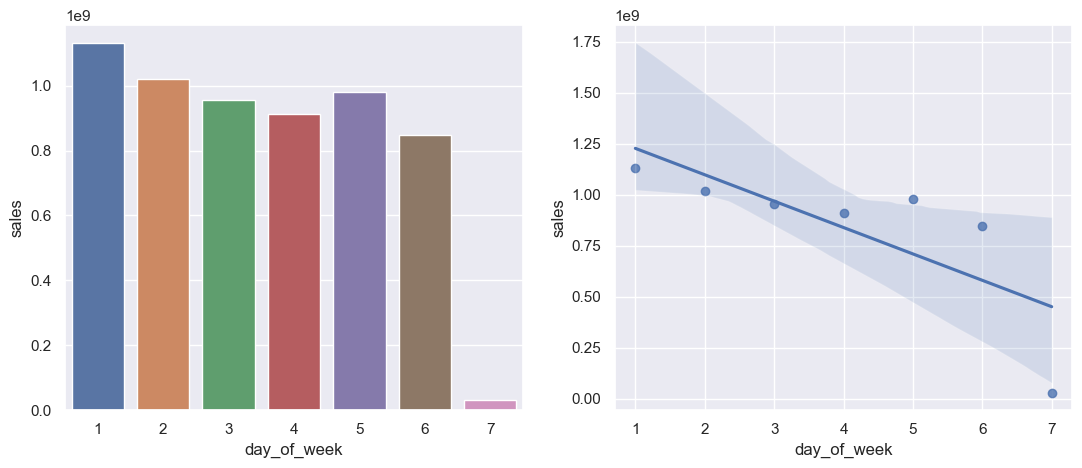

In [65]:
aux1 = df4[ [ 'day_of_week', 'sales' ] ].groupby('day_of_week').sum().reset_index()

plt.subplot( 1, 2, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 )

plt.subplot( 1, 2, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 )

### H12: Vender menos nos feriados escolares.
**FALSA** Comparando a média de venda em dias com e sem aula, os sem aula levam vantagem.

<Axes: xlabel='school_holiday', ylabel='sales'>

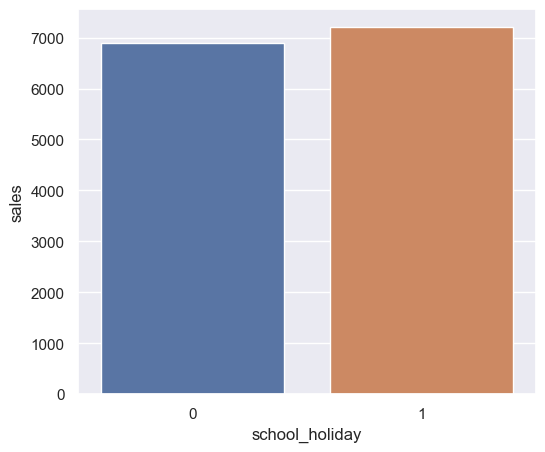

In [66]:
aux1 = df4[ [ 'school_holiday', 'sales' ] ].groupby('school_holiday').mean().reset_index()

plt.subplot( 1, 2, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 )

### 4.2.1 Hipothesis Summary

In [67]:
tab = [ [ 'Hypothesis', 'Conclusion', 'Relevance' ],
        [ 'H1 - assortment', 'True', 'Low' ],
        [ 'H2 - competitors_distance', 'False', 'Medium' ],
        [ 'H3 - competitors_since', 'False', 'Medium' ],
        [ 'H4 - promo_time_week', 'False', 'Low' ],
        [ 'H5 - ', '-', '-' ],
        [ 'H6 - promo2', 'False', 'High' ],
        [ 'H7 - state_holiday', 'True', 'Low' ],
        [ 'H8 - year', 'False', 'High' ],
        [ 'H9 - month', 'True', 'High' ],
        [ 'H10 - day', 'True', 'Medium' ],
        [ 'H11 - day_of_week', 'True', 'High' ],
        [ 'H12 - school_holiday', 'False', 'Low' ],
      ]

hypothesis_summary = tabulate( tab, headers='firstrow' )
print( hypothesis_summary )

Hypothesis                 Conclusion    Relevance
-------------------------  ------------  -----------
H1 - assortment            True          Low
H2 - competitors_distance  False         Medium
H3 - competitors_since     False         Medium
H4 - promo_time_week       False         Low
H5 -                       -             -
H6 - promo2                False         High
H7 - state_holiday         True          Low
H8 - year                  False         High
H9 - month                 True          High
H10 - day                  True          Medium
H11 - day_of_week          True          High
H12 - school_holiday       False         Low


## 4.3 Multivariada

Como as variáveis se relacionam 2:1, 3:1, etc com a variável resposta?

### 4.3.1 Numerical attributes

In [68]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_in_months', 'promo_since', 'promo_time_week'],
      dtype='object')

In [69]:
num_attributes = num_attributes.drop([ 'open', 'customers' ], axis=1)

In [70]:
num_attributes.columns

Index(['store', 'day_of_week', 'sales', 'promo', 'school_holiday',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'is_promo'],
      dtype='object')

<Axes: >

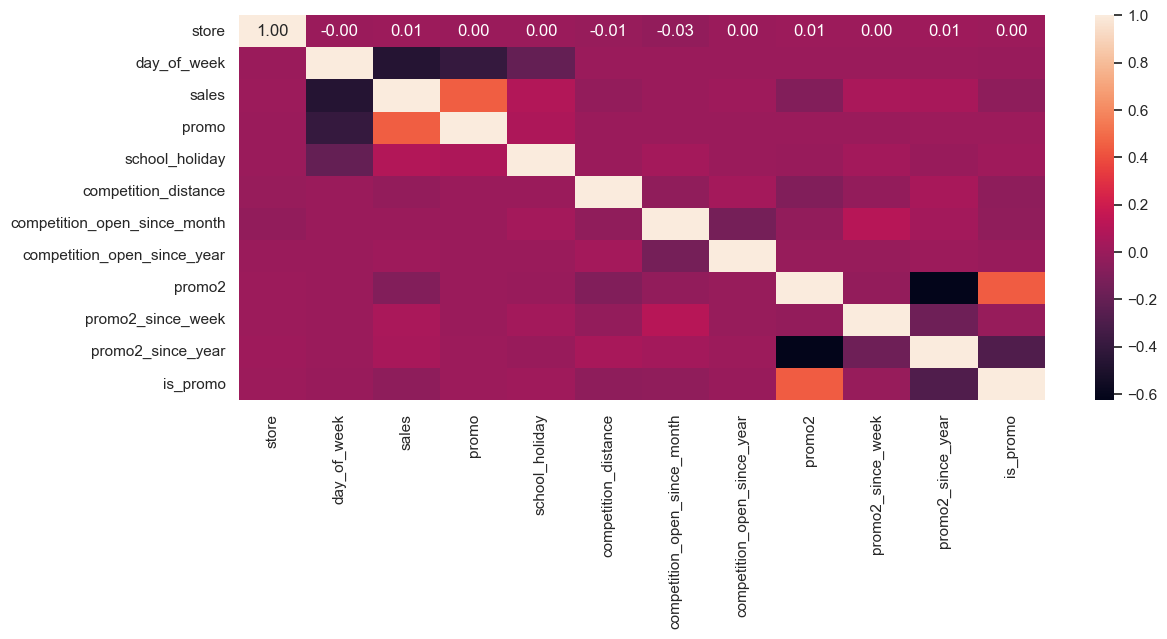

In [71]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True, fmt=".2f")

### 4.3.2 Categorical attributes

In [72]:
cat_attributes = df4.select_dtypes( include='object' )
cat_attributes = cat_attributes.drop( 'year_week', axis=1 )

In [73]:
cat_attributes.head()

,state_holiday,store_type,assortment
0,regular_day,c,basic
1,regular_day,a,basic
2,regular_day,a,basic
3,regular_day,c,extended
4,regular_day,a,basic


<Axes: >

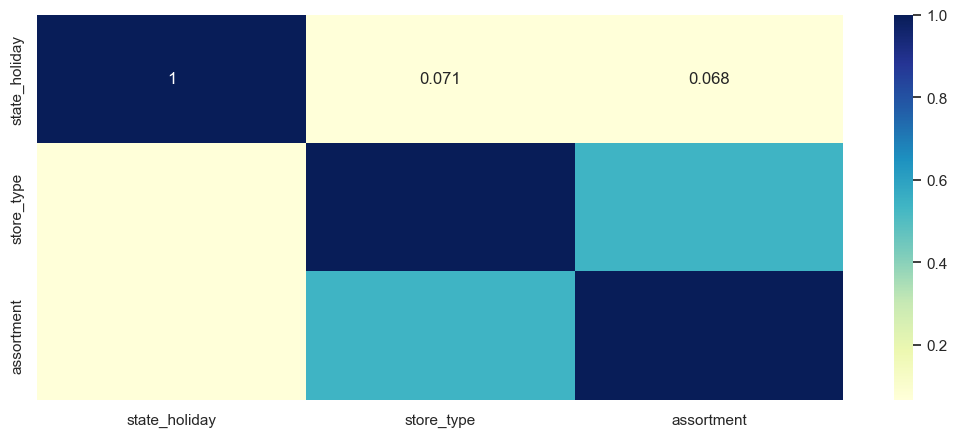

In [74]:
# Selecting categorical data
cat_attributes = df4.select_dtypes( include='object' )
cat_attributes = cat_attributes.drop( 'year_week', axis=1 )

# Calculating Cramer V matrix.
a1 = cramer_v( cat_attributes['state_holiday'], cat_attributes['state_holiday'] )
a2 = cramer_v( cat_attributes['state_holiday'], cat_attributes['store_type'] )
a3 = cramer_v( cat_attributes['state_holiday'], cat_attributes['assortment'] )

a4 = cramer_v( cat_attributes['store_type'], cat_attributes['state_holiday'] )
a5 = cramer_v( cat_attributes['store_type'], cat_attributes['store_type'] )
a6 = cramer_v( cat_attributes['store_type'], cat_attributes['assortment'] )

a7 = cramer_v( cat_attributes['assortment'], cat_attributes['state_holiday'] )
a8 = cramer_v( cat_attributes['assortment'], cat_attributes['store_type'] )
a9 = cramer_v( cat_attributes['assortment'], cat_attributes['assortment'] )

# Cramer V matrix
d = pd.DataFrame( { 'state_holiday': [a1, a2, a3],
                    'store_type':    [a4, a5, a6], 
                    'assortment':    [a7, a8, a9] } )

d = d.set_index( d.columns )

sns.heatmap( d, annot=True, cmap="YlGnBu" )

# 5 DATA PREPARATION

CRISP-DS: DATA MODELING

In [154]:
df5 = df4.copy()

## 5.0 Project status and Topic meaning

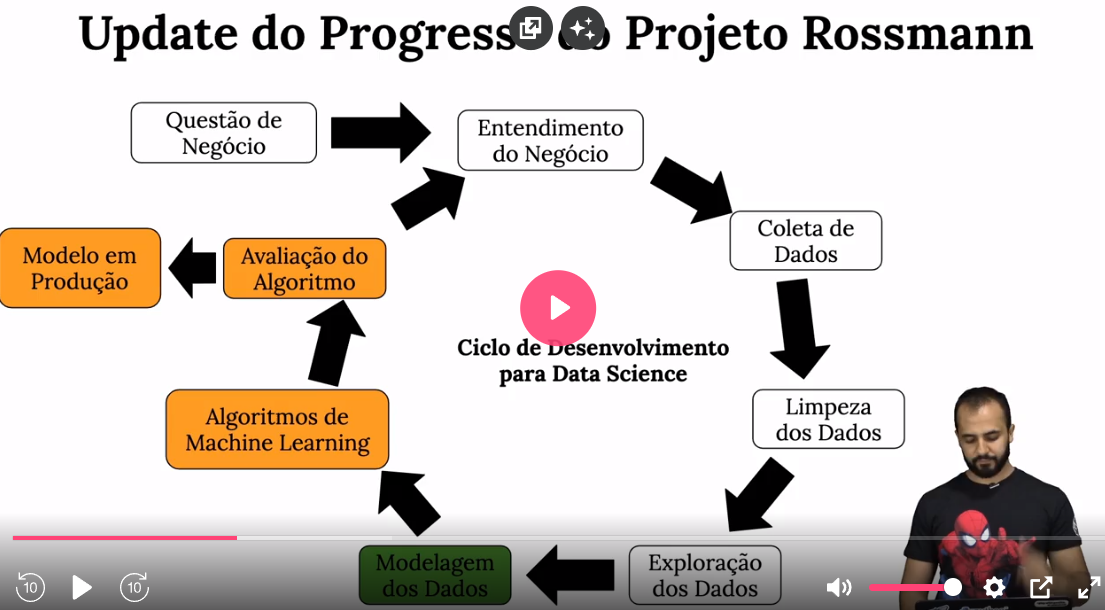

In [155]:
Image( 'img/progresso.png' )

Os modelos de ML funcionam melhor com dados numéricos e na mesma escala.

- **1 -** Normalization (para Gaussiana): Rescala o centro para zero com desvio padrão igual a 1.
- **2 -** Rescaling (para não Gaussiana): Rescala para um intervalo de 0 a 1.
- **3 -** Transformation: Encoding (categorical to numerical), and data nature transformation (months are cyclical, for exemple).

## 5.1 Standardization

x_new = (x_i - media)/desv

Analyzing topic 4.1 Univariate Analysis, we cannot see clearly any variate available for normalization.

In [156]:
# from sklearn.preprocessing import StandardScaler

# # Assuming 'data' is your dataset
# scaler = StandardScaler()
# data_standardized = scaler.fit_transform(data)

## 5.2 Rescaling

In [157]:
num_feat = df5.select_dtypes( include=[ 'int32', 'int64', 'float64' ] )
num_feat.columns

Index(['store', 'day_of_week', 'sales', 'promo', 'school_holiday',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'is_promo', 'year', 'month', 'day', 'week_of_year',
       'competition_time_in_months', 'promo_time_week'],
      dtype='object')

Robust Scaler (data with strong outliers) or Min-Max Scaler (no outliers)

In [158]:
# Testing Outliers
#sns.boxplot(x=df5['promo_time_week'])
#plt.xlabel("x")
#plt.show();

In [159]:
# LINEAR VARIABLES
mms = MinMaxScaler()
rs = RobustScaler()

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open( 'parameter/year_scaler.pkl', 'wb' ) )

# competition_distance - Robust
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( 'parameter/competition_distance_scaler.pkl', 'wb' ) )

# competition_time_in_months
df5['competition_time_in_months'] = rs.fit_transform( df5[['competition_time_in_months']].values )
pickle.dump( rs, open( 'parameter/competition_time_in_months_scaler.pkl', 'wb' ) )

# promo_time_week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( mms, open( 'parameter/promo_time_week_scaler.pkl', 'wb' ) )

## 5.3 Encoding

### 5.3.1 Categorical Encoding

In [160]:
# One Hot Encoding (google image it to check)
# category  - >  hot    warm    cold
#   hot           1      0       0
#  cold           0      0       1
#  warm           0      1       0


# Label Encoding (just change names to numbers)
# red, yellow, blue -> 1, 2, 3


# Ordinal Encoding (change names to numbers respecting an order)
# warm, cold, hot -> 2, 1, 3


# Target Encoding (applied in features with many categories)
# Its name is a hint: it works with the target variable (in our case, it's sales).
# Stores a, b, c, d, e, f, g, h, i, f, etc...
# Total Sales: 100
# 'a' sales: 12. New 'a' value: 0.12
# 'b' sales: 2. New 'b' value: 0.02
# 'c' sales: 4. New 'c' value: 0.04
# ...
# 'f' sales: 9. New 'f' value: 0.09
# 'g' sales: 12. New 'g' value: 0.12
# ...


# Frequency Encoding (applied in features with many categories)
# It takes the category appearence frequency as its new value.



# Embedding Encoding (used in NLP)
# Analyzes the context of which the categories appear.



In [161]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'], dtype=int)

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( 'parameter/store_type_encoding.pkl', 'wb' ) )


# assortment - Ordinal Encoding
assort_dict = { 'basic': 1, 'extra': 2, 'extended': 3 }
df5['assortment'] = df5['assortment'].map( assort_dict )

### 5.3.2 Response Variable Transformation

Transforming Poisson into Gaussian

- Logarithm
- Box-Cox
- Cube-root
- Sqrt
- Sine/Cosine

In [162]:
df5['sales'] = np.log1p( df5['sales'] )

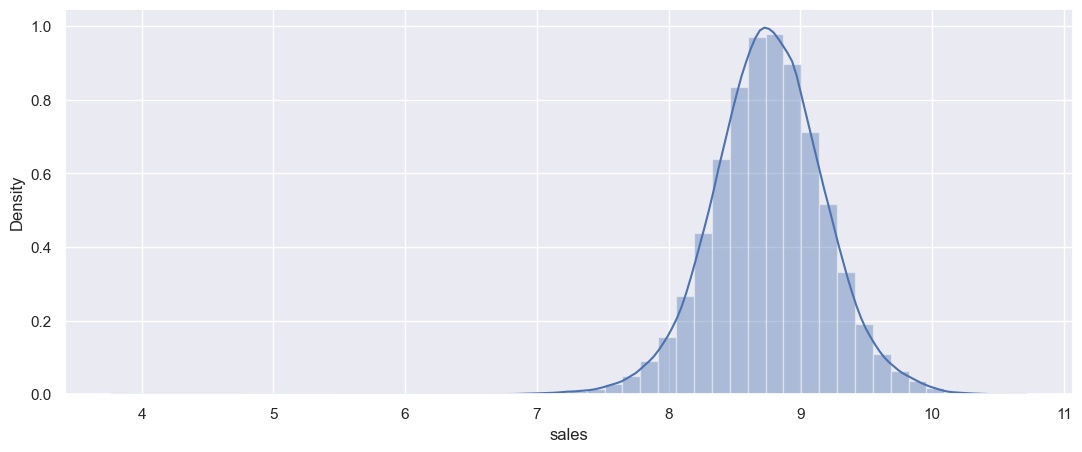

In [163]:
sns.distplot( df5['sales'] );

### 5.3.3 Cyclical Features Encoding

In [164]:
# CYCLICAL FEATURES ENCODING

# day_of_week
df5['dayweek_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['dayweek_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day
df5['daymonth_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['daymonth_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week_of_year
df5['weekyear_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['weekyear_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# 6 FEATURE SELECTION

CRISP-DS: DATA MODELING

In [165]:
df6 = df5.copy()

## 6.0 

CRISP-DS: DATA MODELING

Occam's Razor: O mais simples é essencial para um algoritmo de ML.

In [86]:
# FILTER METHODS (Univariada)

#Relevância através da correlação entre variáveis

#             |       Numérica       |                 Categórica
#----------------------------------------------------------------------------------
# Numérica    |    corr. Pearson     |     LDA (linear discriminant analysis)
#----------------------------------------------------------------------------------
# Categórica  |        Anova         |           Chi-Square / Cramer's V

# Não considera a força de múltiplas variáveis que se reforçam para agir na variável alvo.

In [87]:
# EMBEDDED METHODS (por importância / embutido)
# Já embutido em alguns algoritmos

# Random Forest
# Gini impurity: Determina o grau de importância de uma feature ao usá-la para dividir um conjunto de dados em dois subconjuntos. Se esses
# subconjuntos forem bastante homogêneos entre si, a feature tem bastante importância. Caso contrário, tem baixa importância.

# Lasso / Ridge -> Coefficients Importance

In [88]:
# Wrapper Methods (por subset)

# Testa variável por variável em vários ciclos rodando algoritmos de ML. Se ao adicionar uma variável, a performance aumenta, ela é mantida. Caso 
# contrário, ela é removida.

# ALGORITMO BORUTA

## 6.1 Splitting dataframe between training and test dataset

In [166]:
df6.sample(3)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_in_months,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,dayweek_sin,dayweek_cos,month_sin,month_cos,daymonth_sin,daymonth_cos,weekyear_sin,weekyear_cos
243579,787,3,2014-12-24,8.932345,0,1,2,3,0.141935,6,2009,0,52,2014,0,0.5,12,24,52,2014-51,2009-06-01,0.689189,2014-12-22,0.287016,0,0,0,1,-0.974928,-0.222521,-2.449294e-16,1.000000,0.587785,-0.809017,0.992709,0.120537
369583,517,1,2014-08-11,8.684063,0,1,0,3,3.251613,8,2014,0,33,2014,0,0.5,8,11,33,2014-32,2014-08-01,-0.216216,2014-08-11,0.287016,0,0,0,1,0.781831,0.623490,-8.660254e-01,-0.500000,0.994522,-0.104528,0.822984,0.568065
83518,1009,1,2015-05-18,8.740657,1,0,0,1,-0.338710,7,2004,1,10,2014,0,1.0,5,18,21,2015-20,2004-07-01,1.567568,2014-03-03,0.430524,0,0,0,1,-0.974928,-0.222521,5.000000e-01,-0.866025,0.866025,0.500000,0.568065,0.822984


In [167]:
cols_drop = [ 'week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )

In [168]:
# Splitting last 6 weeks of sales as sample for testing.
six_week_ago = df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days = 6*7 )

In [169]:
# training dataset
x_train = df6[ df6['date'] < six_week_ago ]
y_train = x_train['sales']

# test dataset
x_test = df6[ df6['date'] >= six_week_ago ]
y_test = x_test['sales']

print( 'Training Min Date: {}'.format( x_train['date'].min() ) )
print( 'Training Max Date: {}'.format( x_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( x_test['date'].min() ) )
print( 'Test Max Date: {}'.format( x_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [93]:
x_train.head(1)

,store,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,competition_time_in_months,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,dayweek_sin,dayweek_cos,month_sin,month_cos,daymonth_sin,daymonth_cos,weekyear_sin,weekyear_cos
47945,1,2015-06-18,8.443762,1,0,2,1,-0.170968,9,2008,0,25,2015,0,1.0,0.891892,0.287016,0,0,0,1,-0.781831,0.62349,1.224647e-16,-1.0,0.951057,0.309017,0.663123,0.748511


In [170]:
# training and test dataset
x_train_n = x_train.drop( [ 'date', 'sales' ], axis=1 ).values
y_train_n = y_train.values.ravel()

# define RandomForestRegressor
rf = RandomForestRegressor( n_jobs=-1 )

# define Boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( x_train_n, y_train_n )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	12
Tentative: 	0
Rejected: 	15


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	12
Tentative: 	0
Rejected: 	15


### 6.2.1 Best features from Boruta

In [171]:
cols_selected = boruta.support_.tolist()

x_train_fs = x_train.drop( [ 'date', 'sales' ], axis=1 )
cols_selected_boruta = x_train_fs.iloc[ :, cols_selected ].columns

cols_not_selected_boruta = np.setdiff1d( x_train_fs.columns, cols_selected_boruta )

In [176]:
cols_selected_boruta = list(cols_selected_boruta)
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_in_months',
 'promo_time_week']

In [173]:
cols_not_selected_boruta

array(['daymonth_cos', 'daymonth_sin', 'dayweek_cos', 'dayweek_sin',
       'is_promo', 'month_cos', 'month_sin', 'school_holiday',
       'state_holiday_christmas', 'state_holiday_easter_holiday',
       'state_holiday_public_holiday', 'state_holiday_regular_day',
       'weekyear_cos', 'weekyear_sin', 'year'], dtype=object)

In [174]:
print(hypothesis_summary)

Hypothesis                 Conclusion    Relevance
-------------------------  ------------  -----------
H1 - assortment            True          Low
H2 - competitors_distance  False         Medium
H3 - competitors_since     False         Medium
H4 - promo_time_week       False         Low
H5 -                       -             -
H6 - promo2                False         High
H7 - state_holiday         True          Low
H8 - year                  False         High
H9 - month                 True          High
H10 - day                  True          Medium
H11 - day_of_week          True          High
H12 - school_holiday       False         Low


In [99]:
# Compare hypothesis_summary and cols_selected_boruta

## 6.3 Manual Feature Selection

In [183]:
# boruta features
cols_selected_boruta = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year',
                         'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_in_months', 'promo_time_week' ]

cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year',
                  'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_in_months', 'promo_time_week', 'dayweek_sin', 'dayweek_cos', 
                  'month_sin', 'month_cos', 'daymonth_sin', 'daymonth_cos', 'weekyear_sin', 'weekyear_cos' ]

# cols to add
feat_to_add = [ 'date', 'sales' ]

# final features
cols_selected_full = cols_selected.copy()
cols_selected_full.extend( feat_to_add )

# 7 MACHINE LEARNING ALGORITHMS

CRISP-DS: ML Algorithms

### Algoritmos supervisionados

TREINAMENTO: Compara outras entradas com variável alvo. Tenta identificar padrão.


TAREFA SUPERVISIONADA - VARIÁVEL ALVO ROTULADA e é usada no treinamento

1 - Classificação - analisa características disponíveis e divide os dados em categorias. Quando um novo dado é adicionado, coloca ele em uma das classificações.

2 - Regressão - analisa características disponíveis e divide os dados em valores contínuos. Quando um novo dado é adicionado, um novo valor é dado
a ele.

3 - Séries Temporais - aplicando Regressão a uma situação em que se tem informação de tempo corrido, é possível prever tendências futuras.

### Algoritmos não-supervisionados

Sem nenhum rótulo conhecido pelo algoritmo, ele tenta agrupar os dados.

Clusterização/Agrupamento

### Algoritmos semi-supervisionados

REINFORCEMENT LEARNING

Agente age sobre Ambiente
Ambiente recompensa Agente

Damn it, Pavlov.

Exemplo: algoritmo do Netflix

## ML Models

LINEARES

**1 -** Average Model

**2 -** Linear Regression

**3 -** Linear Regression Regularized

NÃO-LINEARES

**4 -** Random Forest Regression

**5 -** XGBoost Regressor

## 7.0 Data

In [184]:
x_train_ml = x_train[ cols_selected ]
x_test_ml = x_test[ cols_selected ]

# Time Series data preparation - includes columns 'date' and 'sales'; taked full period.
x_training = x_train[ cols_selected_full ]

## 7.1 Average Model

In [101]:
aux1 = x_test_ml.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[ [ 'store', 'sales' ] ].groupby('store').mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']


# performance
baseline_result = ml_error( 'Average Model', np.expm1(y_test), np.expm1(yhat_baseline) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [104]:
# Model
lr = LinearRegression().fit( x_train_ml, y_train )

# Prediction
yhat_lr = lr.predict( x_test_ml )

# Performance
lr_result = ml_error( 'Linear Regression', np.expm1(y_test), np.expm1(yhat_lr) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1909.13857,0.304106,2705.655694


### 7.2.1 Linear Regression Model - Cross Validation

In [105]:
model = LinearRegression()
lr_result_cv = cross_validation_timeseries( x_training, 5, 'Linear Regression', model )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1861.12 +/- 588.64,0.3 +/- 0.04,2667.03 +/- 955.67


## 7.3 Linear Regression Regularized - Lasso

In [106]:
# Model
lrr = Lasso( alpha=0.01 ).fit( x_train_ml, y_train )

# Prediction
yhat_lrr = lr.predict( x_test_ml )

# Performance
lrr_result = ml_error( 'Lasso', np.expm1(y_test), np.expm1(yhat_lrr) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Lasso,1909.13857,0.304106,2705.655694


### 7.3.1 Lasso - Cross Validation

In [107]:
model = Lasso( alpha=0.01 )
lrr_result_cv = cross_validation_timeseries( x_training, 5, 'Lasso', model )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,1862.78 +/- 611.54,0.29 +/- 0.04,2700.39 +/- 996.64


## 7.4 Random Forest Regressor

In [108]:
# Model
rf = RandomForestRegressor( n_estimators=50, n_jobs=-1, random_state=42 ).fit( x_train_ml, y_train )

# Prediction
yhat_rf = rf.predict( x_test_ml )

# Performance
rf_result = ml_error( 'Random Forest', np.expm1(y_test), np.expm1(yhat_rf) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest,914.340012,0.139777,1294.912109


### 7.4.1 Random Forest Regressor - Cross Validation

In [ ]:
model = RandomForestRegressor( n_estimators=50, n_jobs=-1, random_state=42 )
rf_result_cv = cross_validation_timeseries( x_training, 5, 'Random Forest', model )
rf_result_cv

## 7.5 XGBoost Regressor

In [ ]:
# Model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                             n_estimators=1000, 
                             eta=0.01, 
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9 ).fit( x_train_ml, y_train )

# Prediction
yhat_xgb = model_xgb.predict( x_test_ml )

# Performance
xgb_result = ml_error( 'XGBoost', np.expm1(y_test), np.expm1(yhat_xgb) )
xgb_result

### 7.5.1 XGBoost Regressor - Cross Validation

In [ ]:
model = xgb.XGBRegressor( objective='reg:squarederror',
                          n_estimators=1000, 
                          eta=0.01, 
                          max_depth=10,
                          subsample=0.7,
                          colsample_bytree=0.9 )
xgb_result_cv = cross_validation_timeseries( x_training, 5, 'XGBoost', model )
xgb_result_cv

## 7.6 Compare Models' Performances

### 7.6.1 Single sample performance

In [ ]:
modeling_result = pd.concat( [ baseline_result, lr_result, lrr_result, rf_result, xgb_result ] )
modeling_result.sort_values( 'RMSE' )

### 7.6.2 Overall Performance

In [ ]:
modeling_result = pd.concat( [ lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv ] )
modeling_result

# 8 HYPERPARAMETER FINE TUNING

CRISP-DS: ML Algorithms

## 8.0 text

**1 -** Random Search: Define valores aleatoriamente para os hiperparâmetros.

Vantagem: Velocidade (adequado para o primeiro ciclo do CRISP); 

Desvantagem: Pode testar conjuntos iguais mais de uma vez. Pode nunca dar certo, já que é aleatório.

.

**2 -** Grid Search: Define todas as combinações possíveis de valores que os hiperparâmetros podem assumir.

Vantagem: Vai encontrar os melhores parâmetros possíveis.

Desvantagem: Pode demorar muito, mas muito mesmo, até meses.

.

**3 -** Bayesian Search: Define os valores dos hiperparâmetros seguindo a teoria de Bayes.

Define os valores baseado em aprendizados anteriores.

Mais rápido que o Grid, mais lento que o Random.

## 8.1 Random Search

In [141]:
param = { 'n_estimators'    : [ 1200, 1500, 1700, 2000, 2500, 3000, 3500, 4000 ], 
          'eta'             : [ 0.01, 0.03, 0.05, 0.07 ], 
          'max_depth'       : [ 1, 3, 5, 7, 9, 11, 13 ], 
          'subsample'       : [ 0.1, 0.3, 0.5, 0.7 ], 
          'colsample_bytree' : [ 0.3, 0.5, 0.7, 0.9 ], 
          'min_child_weight': [ 3, 5, 8, 11, 14, 17, 20 ] }


MAX_EVAL = 30

In [142]:
# Chosen Model: XGBoost

final_result = pd.DataFrame()

for i in range (MAX_EVAL):
    # choose values for parameters randomly
    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    print( 'iter {}'.format(i), hp )
    
    # Model
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                 n_estimators=hp['n_estimators'], 
                                 eta=hp['eta'], 
                                 max_depth=hp['max_depth'],
                                 subsample=hp['subsample'],
                                 colsample_bytree=hp['colsample_bytree'],
                                 min_child_weight=hp['min_child_weight'] )

    # Performance
    result = cross_validation_timeseries( x_training, 5, 'XGBoost', model_xgb )
    final_result = pd.concat( [ final_result, result ] )

final_result.reset_index(drop=True)

iter 0 {'n_estimators': 1200, 'eta': 0.03, 'max_depth': 11, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 5}
iter 1 {'n_estimators': 2500, 'eta': 0.05, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 20}
iter 2 {'n_estimators': 2000, 'eta': 0.01, 'max_depth': 13, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 8}
iter 3 {'n_estimators': 2000, 'eta': 0.05, 'max_depth': 9, 'subsample': 0.3, 'colsample_bytree': 0.5, 'min_child_weight': 11}
iter 4 {'n_estimators': 4000, 'eta': 0.07, 'max_depth': 9, 'subsample': 0.3, 'colsample_bytree': 0.7, 'min_child_weight': 3}
iter 5 {'n_estimators': 3000, 'eta': 0.05, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 11}
iter 6 {'n_estimators': 1700, 'eta': 0.01, 'max_depth': 13, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 5}
iter 7 {'n_estimators': 3000, 'eta': 0.07, 'max_depth': 7, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost,841.84 +/- 453.33,0.15 +/- 0.08,1122.86 +/- 577.34
1,XGBoost,917.17 +/- 548.18,0.16 +/- 0.09,1194.38 +/- 652.07
2,XGBoost,856.65 +/- 475.44,0.15 +/- 0.08,1150.98 +/- 627.93
3,XGBoost,945.32 +/- 587.36,0.17 +/- 0.1,1250.87 +/- 737.75
4,XGBoost,905.21 +/- 538.62,0.16 +/- 0.09,1238.34 +/- 742.02
5,XGBoost,957.94 +/- 659.45,0.17 +/- 0.11,1263.6 +/- 821.53
6,XGBoost,834.79 +/- 442.93,0.15 +/- 0.08,1122.62 +/- 587.22
7,XGBoost,945.22 +/- 557.38,0.17 +/- 0.1,1192.92 +/- 584.12
8,XGBoost,1158.91 +/- 478.66,0.2 +/- 0.08,1622.6 +/- 731.98
9,XGBoost,968.77 +/- 584.87,0.17 +/- 0.1,1277.03 +/- 728.92


In [144]:
final_result.reset_index(drop=False).sort_values('RMSE CV').head(3)

,index,Model Name,MAE CV,MAPE CV,RMSE CV
23,0,XGBoost,838.52 +/- 420.5,0.15 +/- 0.07,1110.08 +/- 503.52
6,0,XGBoost,834.79 +/- 442.93,0.15 +/- 0.08,1122.62 +/- 587.22
0,0,XGBoost,841.84 +/- 453.33,0.15 +/- 0.08,1122.86 +/- 577.34


## 8.2 Final Tuning

In [145]:
# Best Score: iter 23 {'n_estimators': 1700, 'eta': 0.07, 'max_depth': 11, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 3}
#param_tuned = { 'n_estimators'     : 1700, 
#                'eta'              : 0.07, 
#                'max_depth'        : 11, 
#                'subsample'        : 0.7, 
#                'colsample_bytree' : 0.3, 
#                'min_child_weight' : 3 }

In [146]:
# Chosen Model: XGBoost
#model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
#                                    n_estimators=param_tuned['n_estimators'], 
#                                    eta=param_tuned['eta'], 
#                                    max_depth=param_tuned['max_depth'],
#                                    subsample=param_tuned['subsample'],
#                                    colsample_bytree=param_tuned['colsample_bytree'],
#                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train_ml, y_train )
 
# Prediction
#yhat_xgb_tuned = model_xgb_tuned.predict( x_test_ml )

# Performance
#xgb_result_tuned = ml_error( 'XGBoost', np.expm1(y_test), np.expm1(yhat_xgb_tuned) )
#xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost,906.254413,0.137839,1269.515895


In [147]:
#mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
#print( 'MPE: {:.2f}%'.format( mpe*100 ) )

MPE: -2.32%


In [185]:
# Chosen Model: XGBoost

# Bom resultado com n_estimators significamente menor: {'n_estimators': 1200, 'eta': 0.03, 'max_depth': 11, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 5}
param_tuned = { 'n_estimators'     : 1200, 
                'eta'              : 0.03, 
                'max_depth'        : 11, 
                'subsample'        : 0.7, 
                'colsample_bytree' : 0.9, 
                'min_child_weight' : 5 }


# Running the model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'],
                                    colsample_bytree=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train_ml, y_train )
 
# Prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test_ml )

# Performance
xgb_result_tuned = ml_error( 'XGBoost', np.expm1(y_test), np.expm1(yhat_xgb_tuned) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost,870.764959,0.132095,1230.960771


In [186]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
print( 'MPE: {:.2f}%'.format( mpe*100 ) )

MPE: -1.95%


## 8.3 Saving Trained Model

In [150]:
#pickle.dump( model_xgb_tuned, open( 'C:/Users/victo/comunidade_ds/repos/rossman-stores-sales/model/v00_model_rossman.pkl', 'wb' ) )

# 9 MODEL EVALUATION

CRISP-DS: Evaluation

### 0 Motivation

Motivação da tradução do Erro:

Traduzir a performance do modelo em quando esse modelo vai trazer em valor($) para a empresa.

.

**1 -** Performance de modelos de Regressão

MAE (Mean Absolute Error)

MAPE (Mean Absolute Percentage Error)

RMSE (Root Mean Squared Error)

MPE (Mean Percentage Error)

.

**2 -** Performance do Modelo sobre o Negócio

Comparação com Status Quo (resultados já existentes na empresa)

Impacto da métrica alvo sobre o negócio

## 9.0 Theory

### MAE (Mean Absolute Error)

MAE = sum( |y - yhat| ) / N, sendo N o tamanho da amostra.

Atribui peso igual para todos os erros.

Robusto na presença de outliers.

**Fácil entendimento pelo time de negócio!!!!!**

### MAPE (Mean Absolute Percentage Error)

MAPE = sum( | (y - yhat)/y | ) / N, sendo N o tamanho da amostra.

Mostra a incerteza percentual da predição.

**Muito bom para divulgação de resultados!!!!!**

Não pode ser usado se a Variável Resposta conter zero ( 1/y, em que y=0 gera indeterminação).

### RMSE (Root Mean-Square Error)

RMSE = sqrt( sum( (y - yhat)^2 ) / N ), sendo N o tamanho da amostra.

Destaca Outliers devido ao quadrado.

Ideal para medir performance de modelos de ML.

**Deve ser utilizado para análises mais sensíveis.**

### MPE (Mean Percentage Error)

MPE = sum( (y - yhat) / y ) / N, sendo N o tamanho da amostra.

Não pode ser usado para medir a performance do modelo.

**Identificar se o modelo está subestimando ou superestimando a previsão.**

Novamente, como o MAPE, não funciona com variáveis resposta com valores Zero.

### Negócio
Avaliar performance do Modelo: RMSE e MPE.

.

Performance do Modelo sobre o Negócio: MAE, MAPE e MPE.

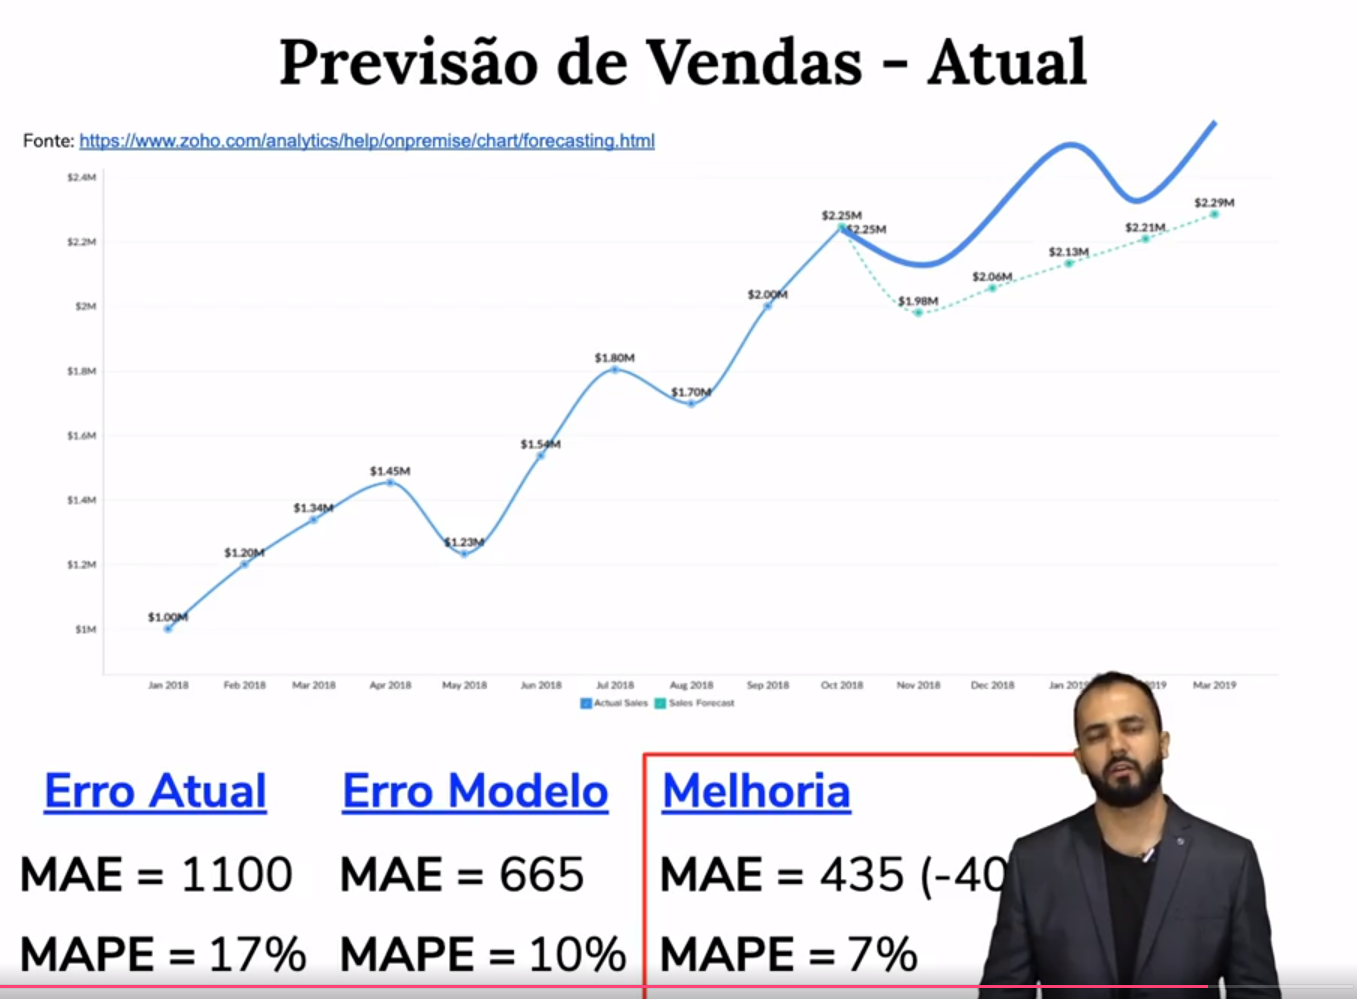

In [106]:
Image( 'img/dash1.png' )

## 9.1 Loading Trained Model

In [187]:
model_xgb_tuned = pickle.load( open( 'C:/Users/victo/comunidade_ds/repos/rossman-stores-sales/model/v00_model_rossman.pkl', 'rb' ) )
yhat_xgb_tuned = model_xgb_tuned.predict( x_test_ml )
xgb_result_tuned = ml_error( 'XGBoost', np.expm1(y_test), np.expm1(yhat_xgb_tuned) )

In [188]:
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost,870.764959,0.132095,1230.960771


In [189]:
df9 = x_test[ cols_selected_full ].copy()

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.2 Business Performance

In [190]:
# sum of predictions
df9_1 = df9[ [ 'store', 'predictions'] ].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[ [ 'store', 'sales', 'predictions' ] ].groupby('store').apply( lambda x: 36*mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={ 0: 'MAE' } )
df9_aux2 = df9[ [ 'store', 'sales', 'predictions' ] ].groupby('store').apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={ 0: 'MAPE' } )

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df9_2 = pd.merge( df9_1, df9_aux3, how='inner', on='store' )

# Scenarios
df9_2['worst_scenario'] = df9_2['predictions'] - df9_2['MAE']
df9_2['best_scenario'] = df9_2['predictions'] + df9_2['MAE']

# order columns
df9_2 = df9_2[ [ 'store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE' ] ]

In [195]:
df9_2.sort_values( 'MAPE', ascending=False ).head(10)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,109007.640625,-14166.647101,232181.928351,123174.287726,0.603931
875,876,201741.484375,21584.547639,381898.421111,180156.936736,0.501025
908,909,246211.171875,-14362.002208,506784.345958,260573.174083,0.496838
606,607,144676.171875,109545.713260,179806.630490,35130.458615,0.405757
549,550,265457.812500,194328.801467,336586.823533,71129.011033,0.402829
197,198,101840.257812,73387.592655,130292.922970,28452.665158,0.374513
482,483,177253.375000,134815.518317,219691.231683,42437.856683,0.363235
270,271,286949.062500,220467.713418,353430.411582,66481.349082,0.353315
323,324,192340.890625,145665.303843,239016.477407,46675.586782,0.342669
969,970,108838.023438,83415.959459,134260.087416,25422.063978,0.339251


<Axes: xlabel='store', ylabel='MAPE'>

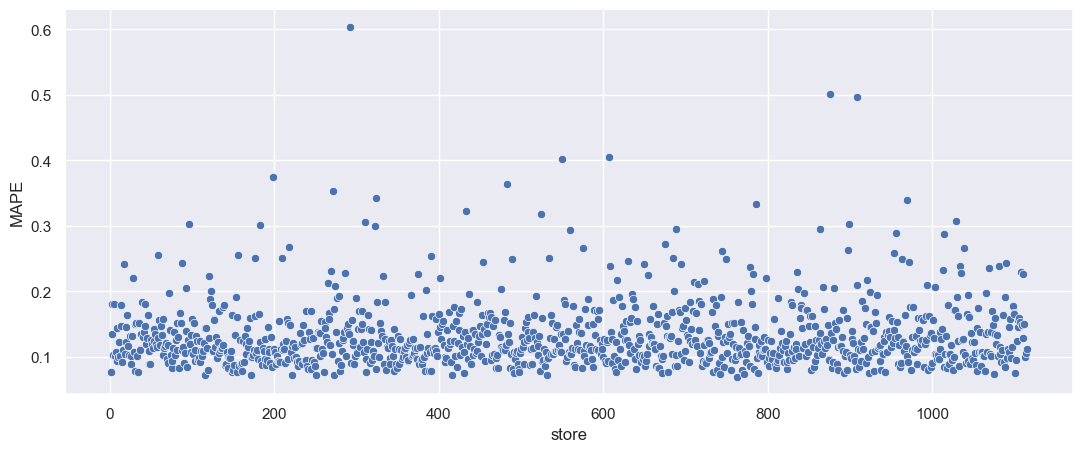

In [192]:
sns.scatterplot( x='store', y='MAPE', data=df9_2 )

## 9.3 Total Performance

In [110]:
df9_3 = df9_2[ [ 'predictions', 'worst_scenario', 'best_scenario' ] ].apply( lambda x: np.sum(x), axis=0 ).reset_index().rename( columns={ 'index': 'Scenario', 0: 'Values' } )
df9_3['Values'] = df9_3['Values'].map( 'R$ {:,.2f}'.format )
df9_3

,Scenario,Values
0,predictions,"R$ 288,253,696.00"
1,worst_scenario,"R$ 252,482,776.09"
2,best_scenario,"R$ 324,024,584.10"


## 9.4 Machine Learning Performance

In [111]:
df9['residuals'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<Axes: xlabel='predictions', ylabel='residuals'>

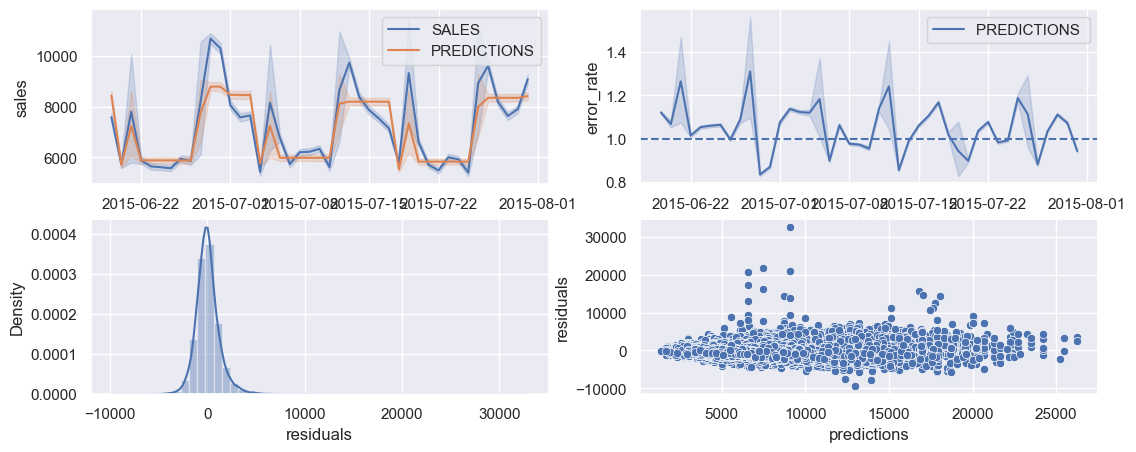

In [112]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9, label='PREDICTIONS ' )
plt.axhline( 1, linestyle='--' )

plt.subplot( 2, 2, 3 )
sns.distplot( df9['residuals'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot(x=df9['predictions'], y=df9['residuals'])

# 10 DEPLOY MODEL TO PRODUCTION

## 10.1 Rossmann Class

In [220]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime
import json


class Rossmann( object ):
    def __init__( self ):
        self.home_path='C:/Users/victo/comunidade_ds/repos/rossman-stores-sales/'
        self.competition_distance_scaler       = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb' ) )
        self.year_scaler                       = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb' ) )
        self.competition_time_in_months_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_in_months_scaler.pkl', 'rb' ) )
        self.promo_time_week_scaler            = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb' ) )
        self.store_type_encoding               = pickle.load( open( self.home_path + 'parameter/store_type_encoding.pkl', 'rb' ) )
        
        
        
    
    def data_cleaning( self, df1 ):
        # 1 DATA CLEANING
    
        ## 1.1 Rename Columns

        cols_old = df1.columns

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )
        
        # rename
        df1.columns = cols_new

        

        ## 1.3 Data Types

        type_value_analysis = pd.concat([df1.dtypes, df1.isna().sum()], axis=1, keys=['Data Types', 'Missing Values'])
        print(type_value_analysis)

        # Reassigning the column 'date' as datetime.
        df1['date'] = pd.to_datetime( df1['date'] )



        ## 1.5 Fillout NA

        # competition_distance: distance in meters to the nearest competitor store

        # Hypothesis:
        # 1. There is no competitor;
        # 2. They are too far away.

        # Solution #01:
        # Change missing data to a distance waaay bigger than any other competitor distance.

        # Take max distance:
        max_dist = df1['competition_distance'].max()

        # Make the NA values significantly bigger distance than max_dist (times 3 in this case).
        df1['competition_distance'] =  df1['competition_distance'].apply( lambda x: (3*max_dist) if math.isnan( x ) else x )


        # competition_open_since_month/year: gives the approximate month/year of the time the nearest competitor was opened

        # Hypothesis:
        # 1. Competition opened store before us;
        # 2. It was simply not record.

        # Solution #01:
        # Use the column 'date' as reference for the opening of competition and watch the impact on the ML algorithms.
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )


        # promo2_since_week/year: describes the year and calendar week when the store started participating in Promo2

        # Hypothesis:
        # 1. promo2 == 0.

        # Check hypothesis:
        # df1.loc[ df1['promo2'] == 0, ['promo2_since_week', 'promo2_since_year'] ].isna().sum()
        # Looks perfect!

        # Solution #01:
        # Fill NA with 'date' values.
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )


        # promo_interval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. 
        # E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

        # Hypothesis:
        # 1. promo2 == 0

        # Check hypothesis?
        # df1.loc[ df1['promo2'] == 0, [ 'promo_interval'] ].isna().sum()
        # Looks perfect!

        # Solution #01:
        # Fill NA with zeros: no promotion interval.
        df1['promo_interval'].fillna( 0, inplace=True )


        # CHECKING IF CONTINUING PROMOTION ('promo2') IS HAPPENING IN EACH SALE

        # promo_interval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. 
        # E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

        # Map month of each sale.
        month_map = { 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec' }
        df1['month_map'] = df1['date'].dt.month.map( month_map )

        # Define if there is a promo in each sale. Create a new column indicating if a sale is done with or without promotion.
        df1['is_promo'] = df1[[ 'promo_interval', 'month_map' ]].apply( lambda x: ( 0 if x['promo_interval'] == 0 
                                                                                    else ( 1 if x['month_map'] in x['promo_interval'].split( ',' ) 
                                                                                           else 0 ) ), axis=1 )
        
        
        
        ## 1.6 Change types

        # Reassign week, month and year columns as integers.
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year']  = df1['competition_open_since_year'].astype( int )
        df1['promo2_since_week']            = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year']            = df1['promo2_since_year'].astype( int )

        
        return df1
    
    
    
    
    def feature_engineering( self, df2 ):
        # FEATURE ENGINEERING
        
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week_of_year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype( int )

        # year_week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition_since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
        df2['competition_time_in_months'] = ( ( df2['date'] - df2['competition_since'] ) / 30 ).apply( lambda x: x.days ).astype( 'int64' )

        # promo_since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        # "%Y-%W-%w has week 1 as the week after the year's first sunday.
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', "%Y-%W-%w" ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] ) / 7 ).apply( lambda x: x.days ).astype( 'int64' )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state_holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )
        
        
        
        # 3 FILTRAGEM DE VARIÁVEIS

        ## 3.1 Filtragem das linhas
        
        df2 = df2[ df2['open'] != 0 ]
        
        
        ## 3.2 Seleção das colunas
        
        # Deletando 'open' porque só tem valor == 1,
        # Deletando 'promo_interval' e 'month_map' porque já foram usada para criar 'is_promo',
        # Deletando 'customers' porque não teremos informação de quantos clientes teremos.
        # Assim como 'customers', checar outras colunas que não existem em test.csv
        cols_drop = [ 'customers', 'open', 'promo_interval', 'month_map' ]
        df2 = df2.drop( cols_drop, axis=1 )
        
        
        return df2


        

    def data_preparation( self, df5 ):
        # 5 DATA PREPARATION

        ## 5.2 Rescaling
        
        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )

        # competition_distance - Robust
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )

        # competition_time_in_months
        df5['competition_time_in_months'] = self.competition_time_in_months_scaler.fit_transform( df5[['competition_time_in_months']].values )

        # promo_time_week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        
        
        ### 5.3.1 Categorical Encoding
        
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'], dtype=int)

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_encoding.fit_transform( df5['store_type'] )

        # assortment - Ordinal Encoding
        assort_dict = { 'basic': 1, 'extra': 2, 'extended': 3 }
        df5['assortment'] = df5['assortment'].map( assort_dict ) 


        ### 5.3.3 Cyclical Features Encoding

        # CYCLICAL FEATURES ENCODING

        # day_of_week
        df5['dayweek_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['dayweek_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day
        df5['daymonth_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['daymonth_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week_of_year
        df5['weekyear_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['weekyear_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        
        # 6 FEATURE SELECTION
        
        ## 6.3 Manual feature selection
        
        # boruta features
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year',
                          'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_in_months', 'promo_time_week', 'dayweek_sin', 'dayweek_cos', 
                          'month_sin', 'month_cos', 'daymonth_sin', 'daymonth_cos', 'weekyear_sin', 'weekyear_cos' ]
        
        
        return df5 [ cols_selected ]
    
    
    
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )

## 10.2 API Handler

In [221]:
import pandas as pd
import pickle
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open( 'C:/Users/victo/comunidade_ds/repos/rossman-stores-sales/model/v00_model_rossman.pkl', 'rb' ) )


# initialize api
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: 
        # there is data
        if isinstance( test_json, dict ): 
            # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: 
            # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparatiom
        df3 = pipeline.data_preparation( df2 ) 
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
         
            
    else:
        # no data
        return Response( '{}', status=200, mimetype='application/json' )
    

if __name__ == '__main__':
    app.run( '0.0.0.0' )

ModuleNotFoundError: No module named 'rossmann'

## 10.3 API Tester

In [206]:
import requests
import json

In [197]:
# loading test dataset
df10 = pd.read_csv( 'C:/Users/victo/comunidade_ds/repos/rossman-stores-sales/data/test.csv' )

# merge test + store dataset
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

In [198]:
# choose store for prediction
df_test = df_test[ df_test['Store'] == 22 ]

# basic cleaning
df_test = df_test[ df_test['Open'] != 0 ]
df_test = df_test[ ~df_test['Open'].isnull() ] # '~df_test['Open'].isnull()' means 'taking anything other than df_test['Open'].isnull()'
df_test = df_test.drop( 'Id', axis=1 )

In [207]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [ ]:
# API Call
url = 'http://0.0.0.0:5000/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post( url, data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )